In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ShuffleSplit, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, ConfusionMatrixDisplay, make_scorer
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
# Attaching project directory
sys.path.append(os.path.dirname(os.getcwd()))

# Pathing imports
from src import GetPath

# Seaborn style
sns.set_theme(style="darkgrid")

In [3]:
DATA_FOLDER = GetPath().repo_data()
ABN_B1 = os.path.join(DATA_FOLDER, 'raw', 'abnormal_b1.csv')
ABN_B2 = os.path.join(DATA_FOLDER, 'raw', 'abnormal_b2.csv')
ABN_B3 = os.path.join(DATA_FOLDER, 'raw', 'abnormal_b3.csv')

RANDOM_STATE = 42
SAMPLE_SIZE = 50
TEST_SIZE = 0.3

np.random.seed(seed=RANDOM_STATE)
random.seed(RANDOM_STATE)

--- Moving Project Path Upward
--- Defined Datapath 
c:\Users\isaac\Desktop\GitHub\Aquaculture-Intelligence\data


In [4]:
# Custom scoring function to prioritize recall for specific classes
def recall_level_10(y_true, y_pred):
    recalls = recall_score(y_true, y_pred, average=None)
    # return recall for class 10
    return np.mean(recalls[2])


def feature_selector(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        experiment_batch, 
        verbose=0,
        model=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    ) -> pd.DataFrame :

    results = []

    # Iterate using from one feature to all feature
    for i in range(len(X_train.columns)):
        # Create the pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
            ('classifier', model)
        ])
        
        # Fit the pipeline
        pipeline.fit(X_train, y_train)

        sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
            input_features=X_train.columns
        )

        # Make predictions
        y_pred = pipeline.predict(X_test)

        result = {
            'data_batch': f"ABN_{experiment_batch}",
            'number_feature': i+1,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
            'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True),
            'recall_level_10': recall_level_10(y_test, y_pred)
        }
        
        if verbose == 1:
            # Message
            print(f"\n--- Inspecting Experiment Batch {experiment_batch} ---")
            print(f"Selected feature: {sel_feat}")
            print(f"--- Results --- \n--- Using {i+1} feature ---")
            print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))
        
        results.append(result)

    return pd.DataFrame(results)

def original_resample(y_train, y_res):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    autopct = "%.2f"
    y_train.value_counts().plot.pie(autopct=autopct, ax=axs[0])
    axs[0].set_title("Original")
    y_res.value_counts().plot.pie(autopct=autopct, ax=axs[1])
    axs[1].set_title("Resample")
    fig.tight_layout()

In [5]:
df = pd.read_csv(ABN_B1)
df.head()

,time_start,time_ end,DO,Hovering BTM,Hovering MID,Hovering SUR,Fast Swim Btm,Fast Swim Mid,Fast Swim SUR,Acc. Ver. MID,...,Agg. Behaviour,Burst Swimming,Resting,Active,BTM,MID,SUR,N,ABN,ABN%
0,00:00:00,00:01:00,6.16,3.0,0.0,0.0,2.0,0.0,0.0,0.0,...,1.0,0.0,7.0,3.0,10.0,0.0,0.0,10.0,0.0,0.0
1,00:01:00,00:02:00,6.10,2.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,7.0,3.0,10.0,0.0,0.0,10.0,0.0,0.0
2,00:02:00,00:03:00,6.08,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,8.0,2.0,10.0,0.0,0.0,10.0,0.0,0.0
3,00:03:00,00:04:00,6.08,5.0,0.0,0.0,4.0,0.0,0.0,2.0,...,0.0,0.0,6.0,4.0,9.0,1.0,0.0,10.0,0.0,0.0
4,00:04:00,00:05:00,5.96,6.0,0.0,0.0,4.0,0.0,0.0,1.0,...,3.0,0.0,6.0,4.0,9.0,1.0,0.0,10.0,0.0,0.0


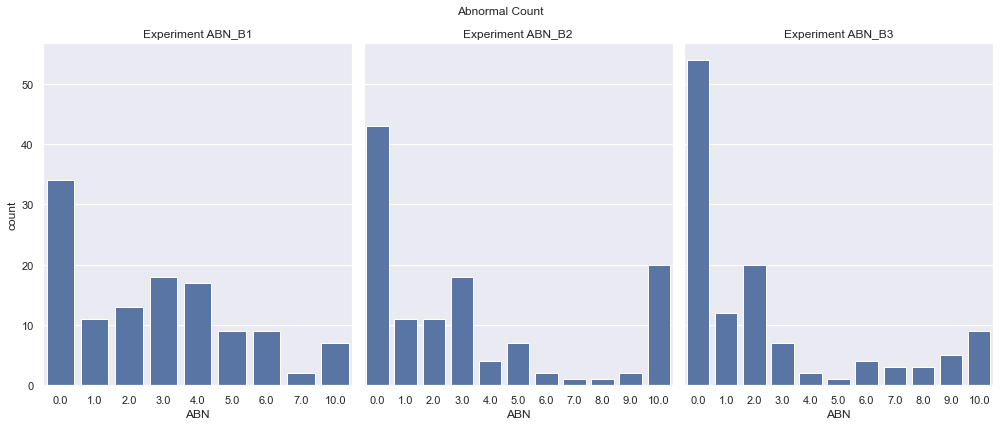

In [6]:
# Checking abnormalities throughout experiments
# Plotting countplot
fig, axes = plt.subplots(figsize=(14,6), nrows=1, ncols=3, sharey='row')
for idx, ax in enumerate(axes.flatten()):
    # Experiment batch
    experiment = f"ABN_B{idx+1}"
    # Load csv data
    df = pd.read_csv(eval(experiment))

    # Plotting countplot
    sns.countplot(df, x='ABN', ax=ax)
    ax.set_title(f"Experiment {experiment}")

fig.suptitle(f"Abnormal Count")
plt.tight_layout()
plt.show()

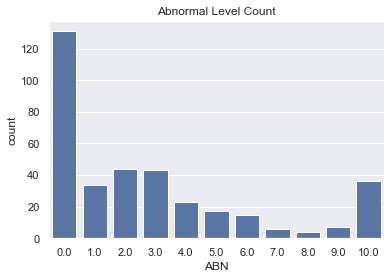

In [7]:
df_all = pd.DataFrame()

for idx in range(3):
    # Experiment batch
    experiment = f"ABN_B{idx+1}"

    df = pd.read_csv(eval(experiment)).dropna()
    df['experiment'] = experiment

    # Load csv data
    df_all = pd.concat([df_all, df]).reset_index(drop=True)

# Plotting countplot
sns.countplot(df_all, x='ABN')
plt.title(f"Abnormal Level Count")
plt.show()

## Relationship between Hovering and Abnormal Level

- Hovering BTM and Abnormal Level (down trend)
- Hovering SUR and Abnormal Level (up trend)

In [8]:
def relation_bars(feature, label='ABN', positions=['BTM', 'MID', 'SUR']):
    for position in positions:
        # Plotting barplot
        fig, axes = plt.subplots(figsize=(14,6), nrows=1, ncols=3, sharey='row')
        for idx, ax in enumerate(axes.flatten()):
            # Experiment batch
            experiment = f"ABN_B{idx+1}"
            # Load csv data
            df = pd.read_csv(eval(experiment))

            sns.barplot(df, x=label, y=f"{feature} {position}", ax=ax)
            ax.set_title(f"Experiment {experiment}")

        fig.suptitle(f"Relationship Between {feature} {position} and {label}")
        plt.tight_layout()
        plt.show

    fig, axes = plt.subplots(figsize=(14,6), nrows=len(positions), ncols=1)
    for idx, ax in enumerate(axes.flatten()):
        sns.barplot(df_all, x='ABN', y=f"{feature} {positions[idx]}", ax=ax)

    fig.suptitle(f"Relationship Between {feature} Position and {label} For All Experiment")
    plt.tight_layout()
    plt.show()

def relation_lines(feature, label='DO', positions=['BTM', 'MID', 'SUR']):
    for position in positions:
        # Plotting lineplot
        fig, axes = plt.subplots(figsize=(12,6), nrows=3, ncols=1, sharey='col')
        for idx, ax in enumerate(axes.flatten()):
            # Experiment batch
            experiment = f"ABN_B{idx+1}"
            # Load csv data
            df = pd.read_csv(eval(experiment))

            sns.lineplot(df, x=label, y=f"{feature} {position}", ax=ax)
            ax.set_title(f"Experiment {experiment}")

        fig.suptitle(f"Relationship Between {feature} {position} and {label}")
        plt.tight_layout()
        plt.show()

def relation_bar(feature, label='ABN'):
    # Every batch experiment
    fig, axes = plt.subplots(figsize=(14,6), nrows=1, ncols=3, sharey='row')
    for idx, ax in enumerate(axes.flatten()):
        # Experiment batch
        experiment = f"ABN_B{idx+1}"
        # Load csv data
        df = pd.read_csv(eval(experiment))

        sns.barplot(df, x=label, y=feature, ax=ax)
        ax.set_title(f"Experiment {experiment}")

    fig.suptitle(f"Relationship Between {feature} and {label}")
    plt.tight_layout()
    plt.show()

    # All experiment
    plt.figure(figsize=(14, 6))
    sns.barplot(df_all, x=label, y=feature)
    plt.title(f"Relationship Between {feature} and {label} For All Experiment")
    plt.show()

def relation_line(feature, label='DO'):
    fig, axes = plt.subplots(figsize=(12,6), nrows=3, ncols=1)
    for idx, ax in enumerate(axes.flatten()):
        # Experiment batch
        experiment = f"ABN_B{idx+1}"
        # Load csv data
        df = pd.read_csv(eval(experiment))

        sns.lineplot(df, x='DO', y=feature, ax=ax)
        ax.set_title(f"Experiment {experiment}")

    fig.suptitle(f"Relationship Between {feature} and {label}")
    plt.tight_layout()
    plt.show()

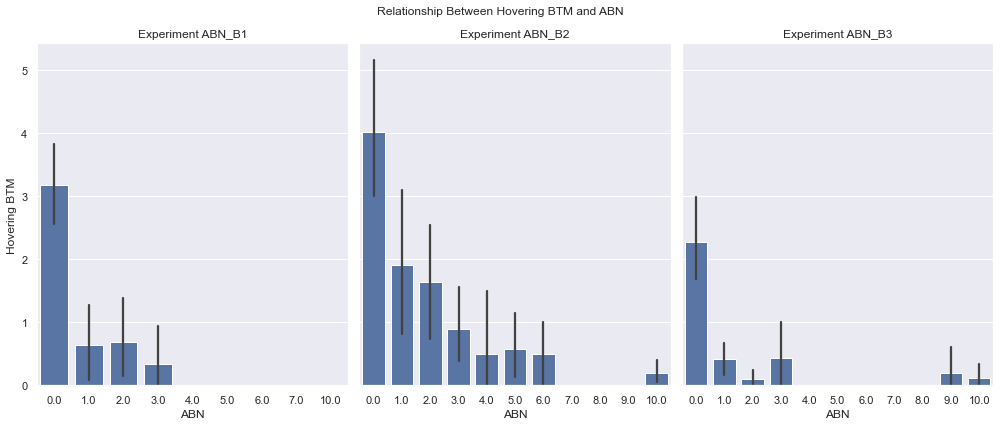

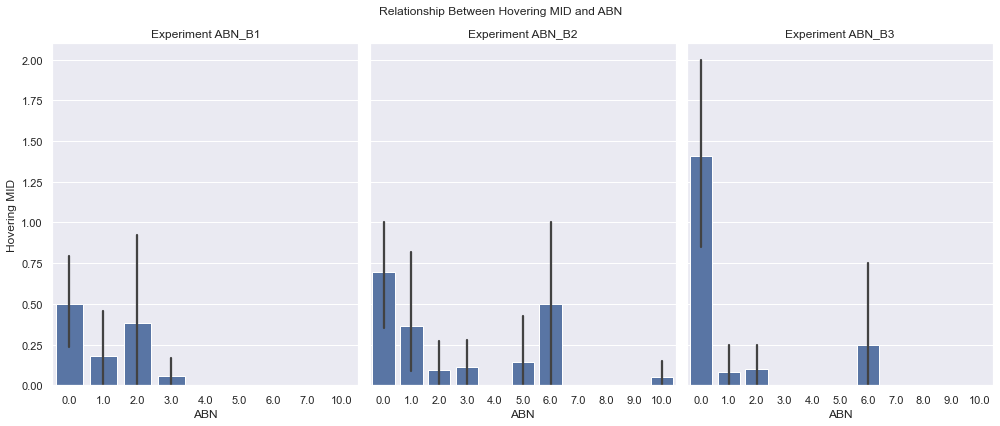

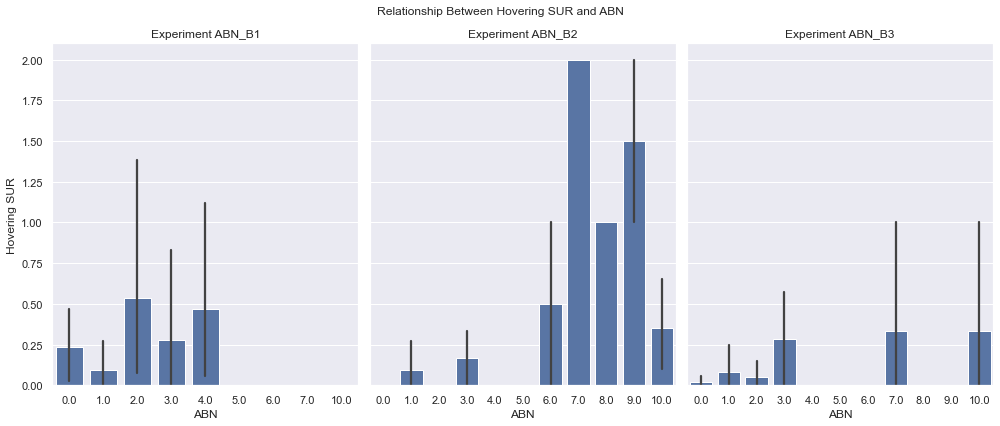

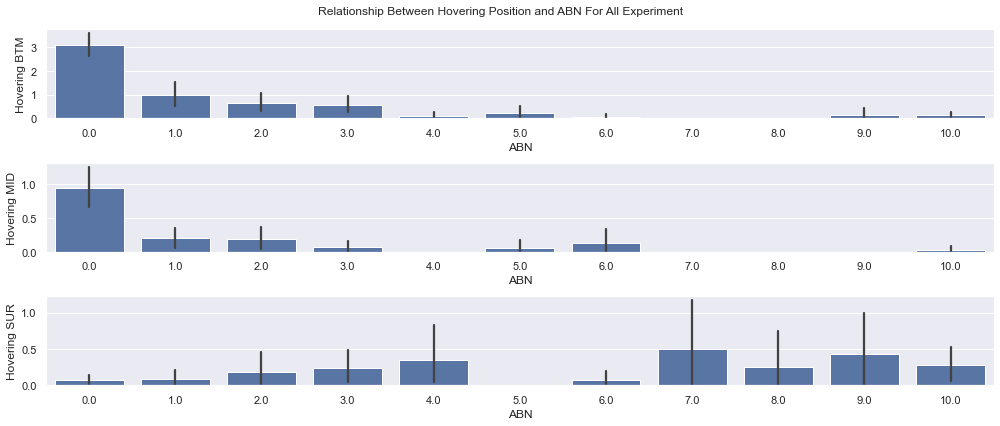

In [9]:
relation_bars(feature='Hovering')

## Relationship between Hovering and DO

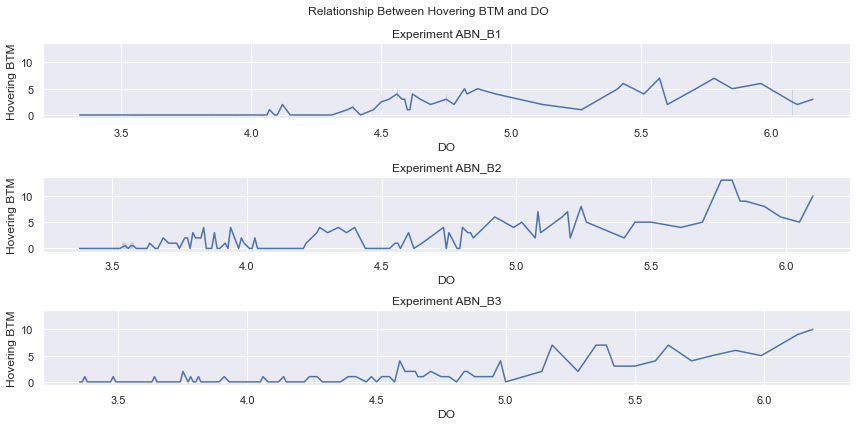

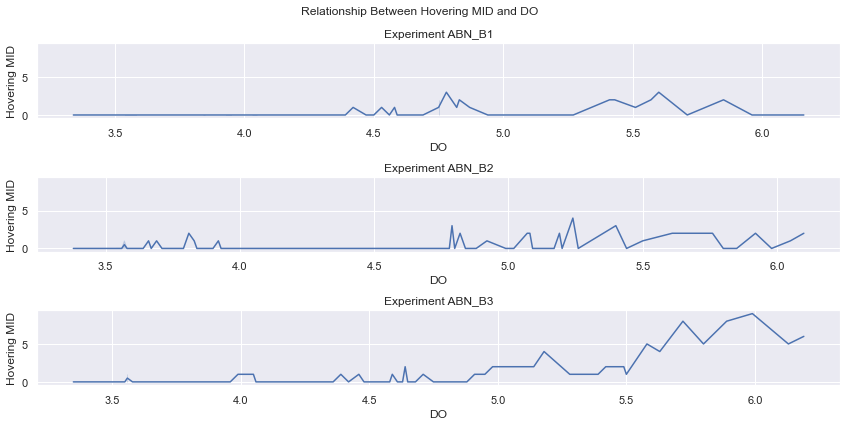

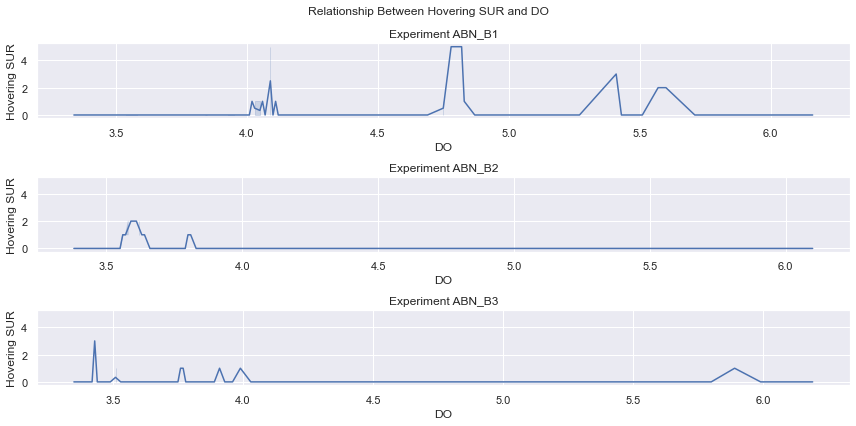

In [10]:
relation_lines(feature='Hovering')

## Relationship between Fast Swim and Abnormal Level
- Fast Swim MID and Abnormal Level (up trend)
- Fast Swim SUR and Abnormal Level (up trend)

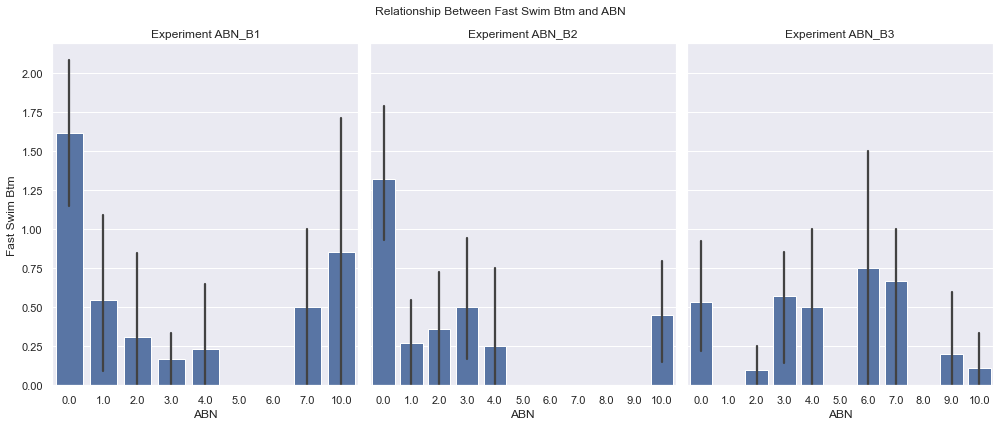

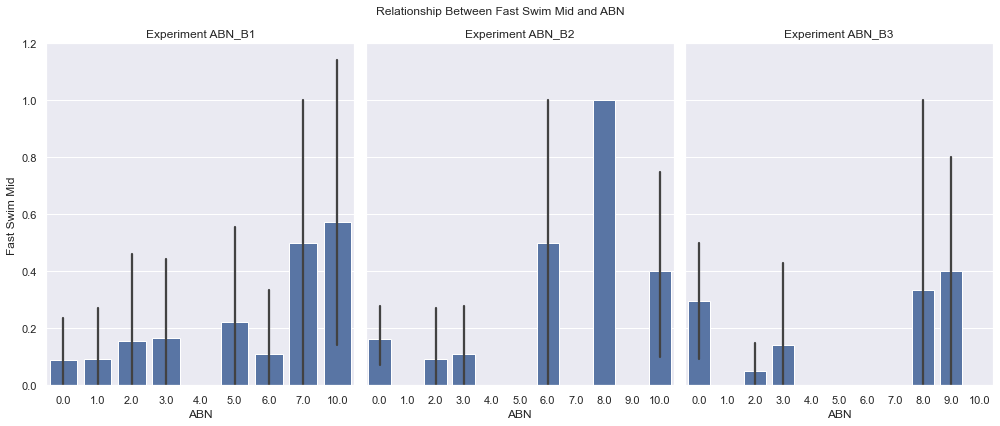

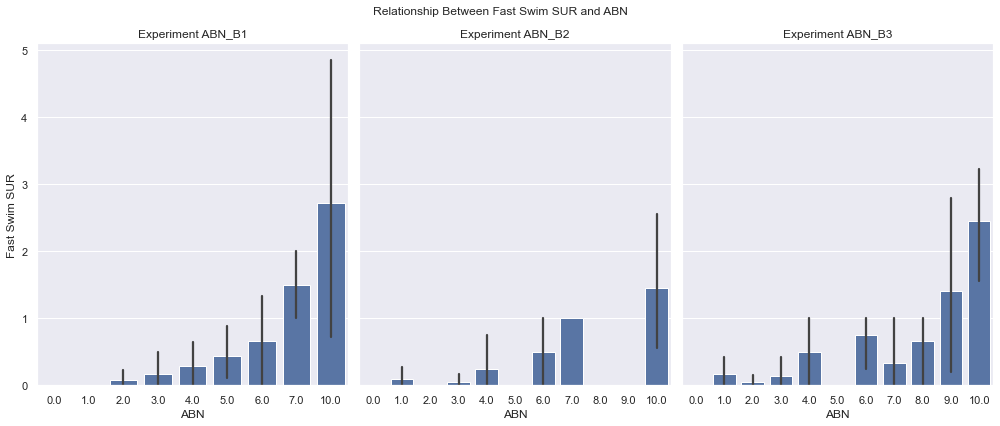

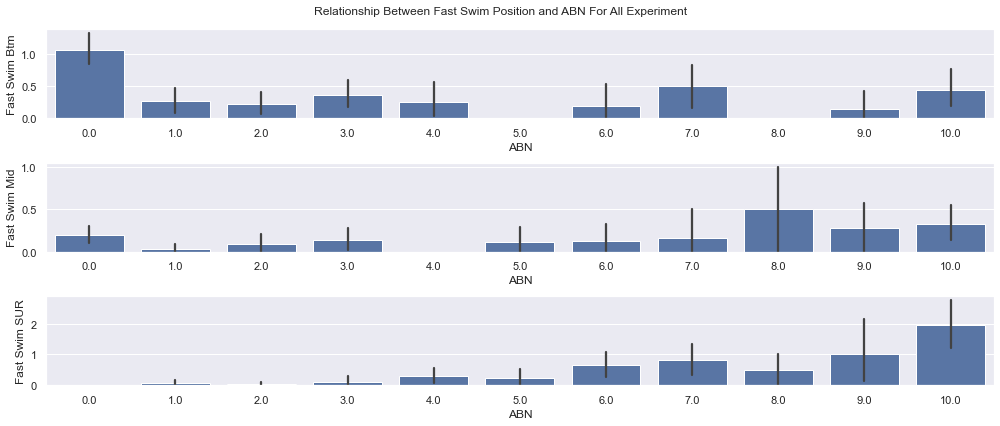

In [11]:
relation_bars(feature='Fast Swim', positions=['Btm', 'Mid', 'SUR'])

## Relationship between Fast Swimming and DO

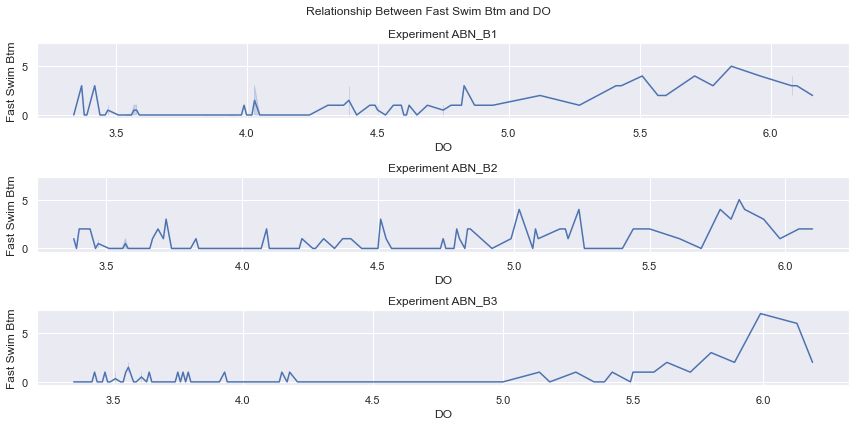

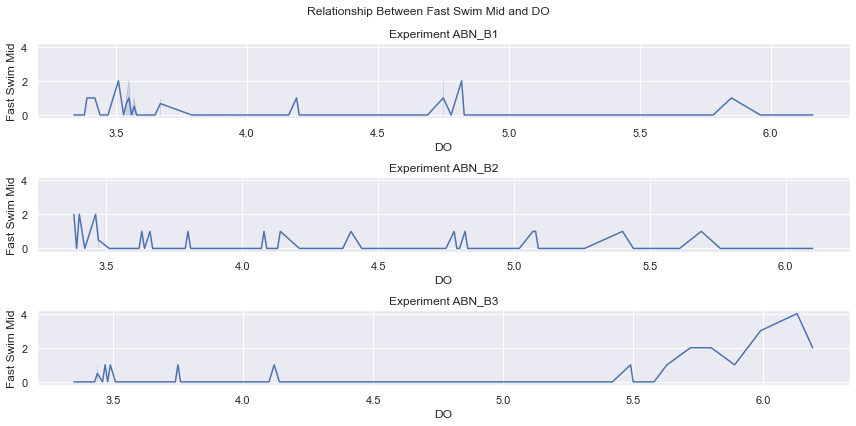

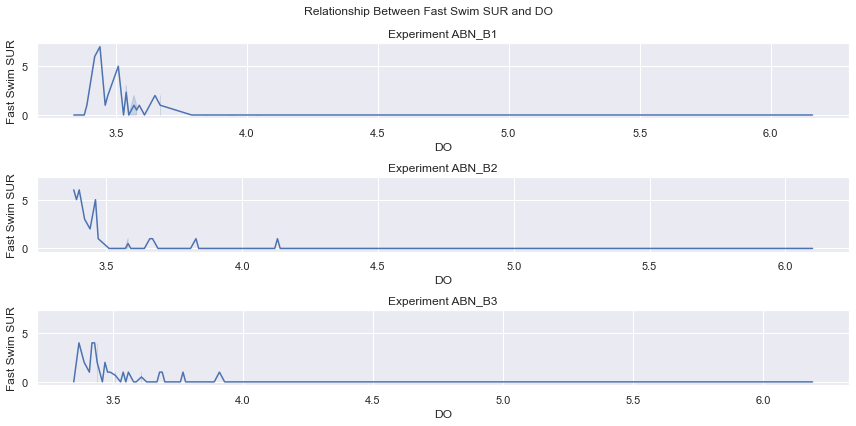

In [12]:
relation_lines(feature='Fast Swim', positions=['Btm', 'Mid', 'SUR'])

## Relationship beween Burst Swimming and Abnormal Level

- Burst Swimming and Abnormal Level (up trend)

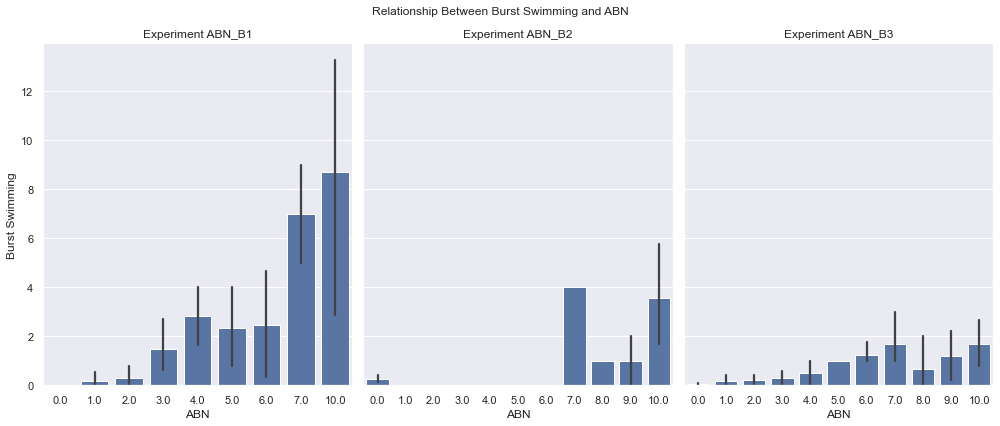

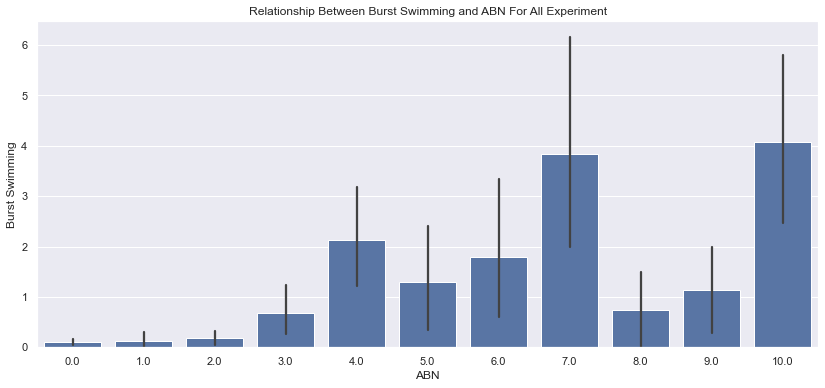

In [13]:
relation_bar(feature='Burst Swimming')

## Relationship between Burst Swimming and DO

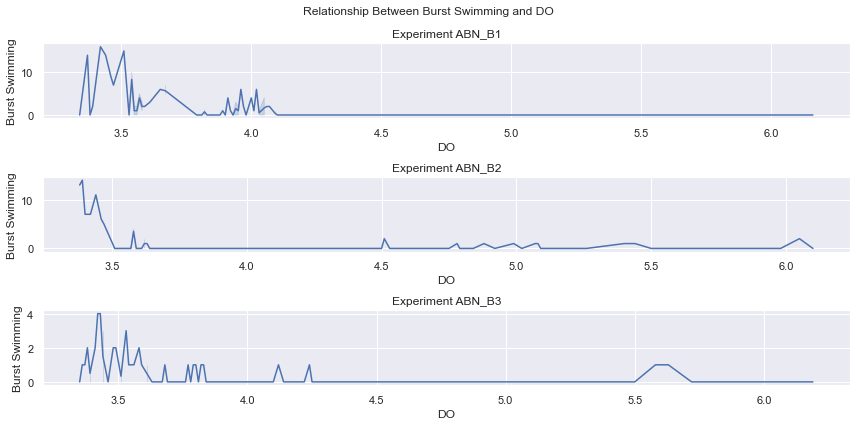

In [14]:
relation_line(feature='Burst Swimming')

## Relationship beween Acc. Ver. Position and Abnormal Level

- Acc. Ver. MID and Abnormal Level (up trend)
- Acc. Ver. SUR and Abnormal Level (up trend)

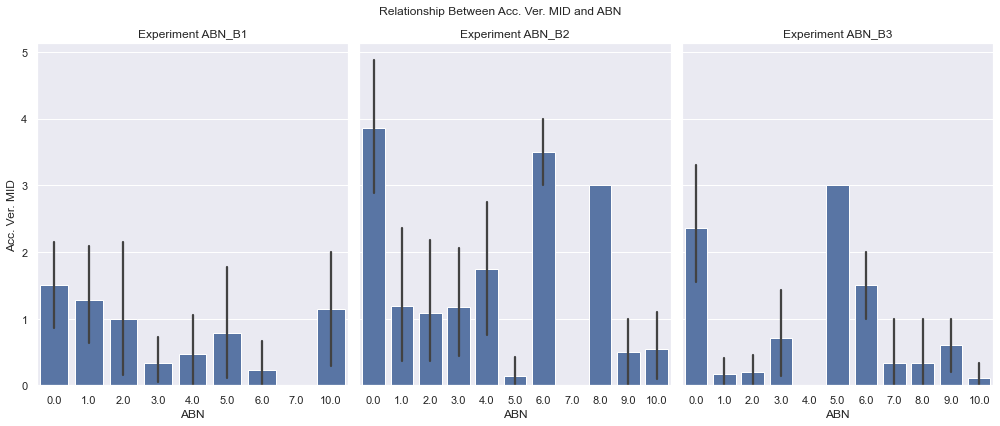

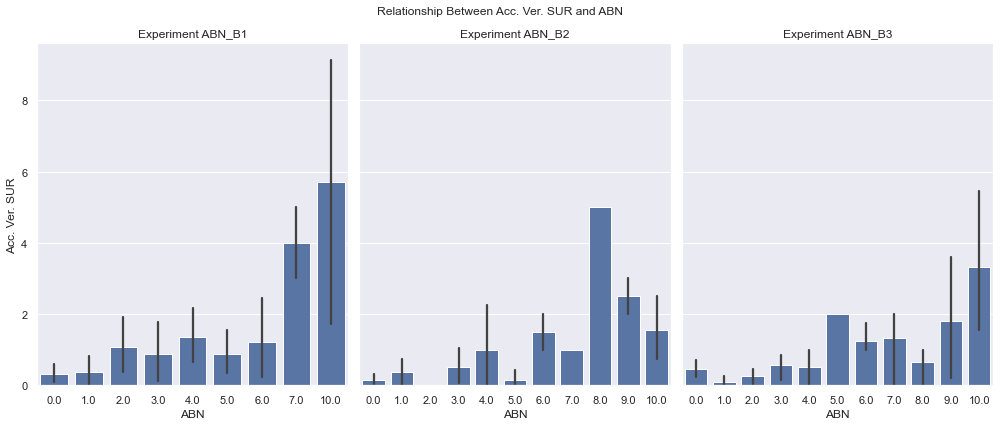

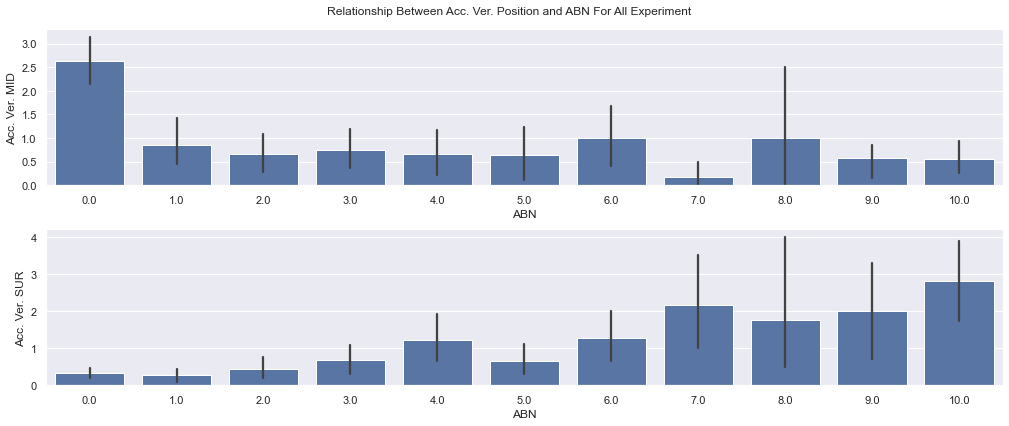

In [15]:
relation_bars(feature='Acc. Ver.', positions=['MID', 'SUR'])

## Relationship between Acc. Ver. Position and DO

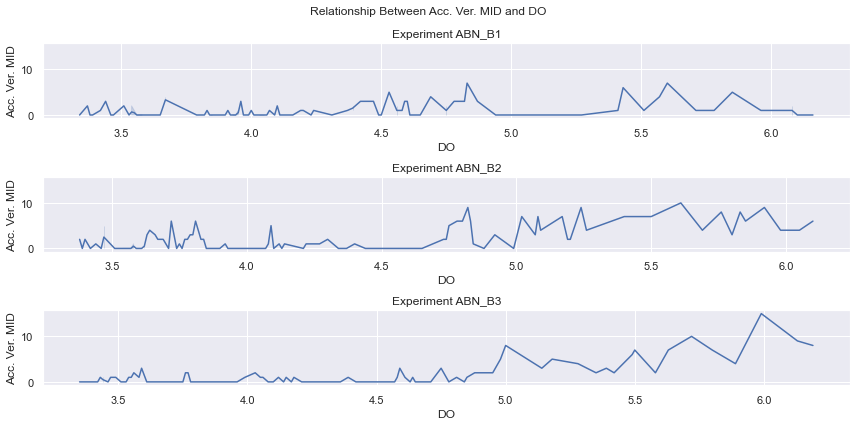

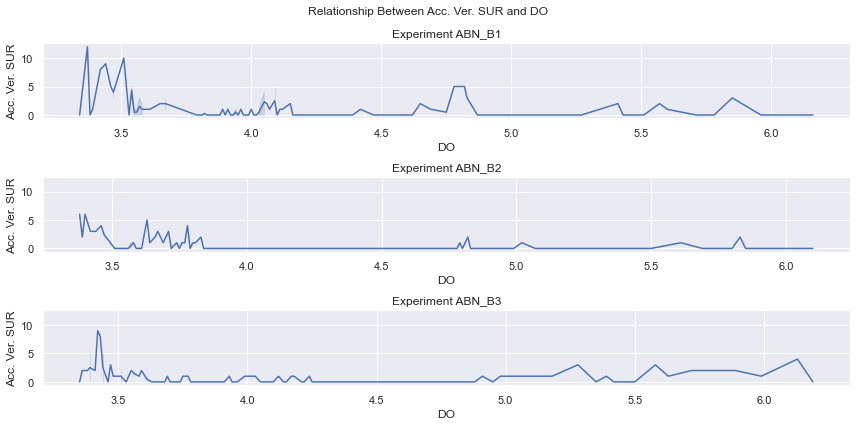

In [16]:
relation_lines(feature='Acc. Ver.', positions=['MID', 'SUR'])

## Relationship between Turning and Abnormal Level
- Turning and Abnormal Level (down trend)

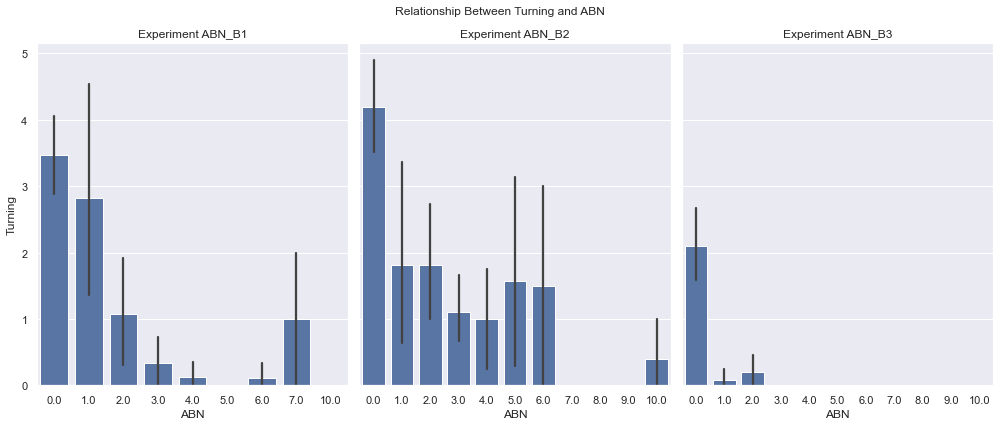

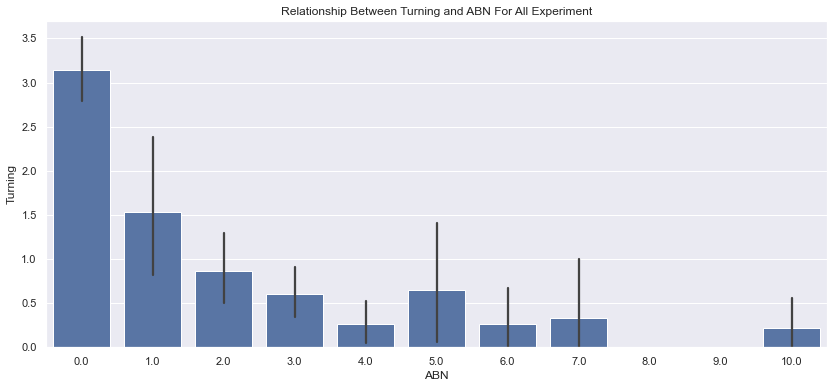

In [17]:
relation_bar(feature='Turning')

## Relationship between Turning and DO

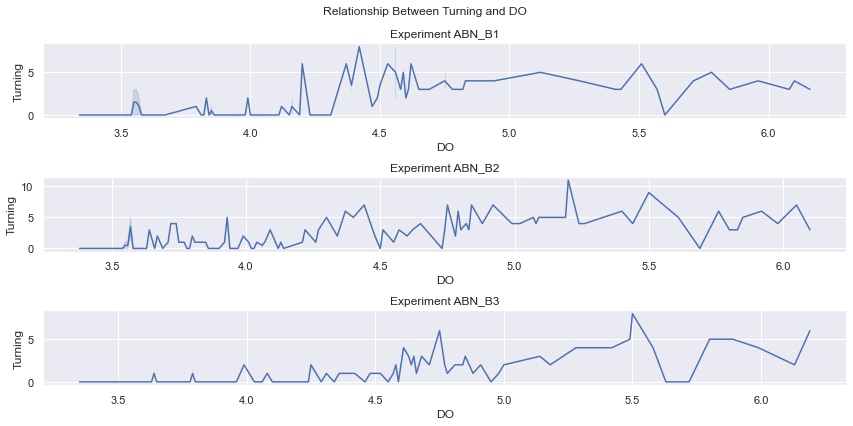

In [18]:
relation_line(feature='Turning')

## Relationship between Agg. Behavior and Abnormal Level

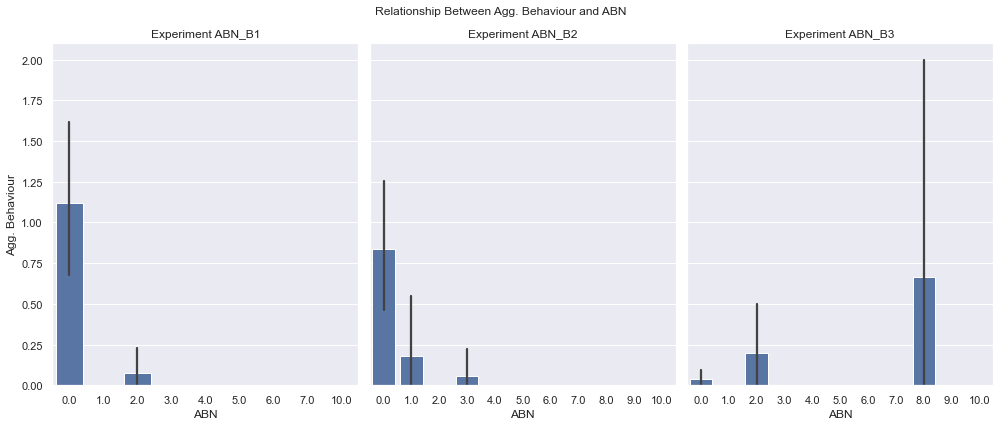

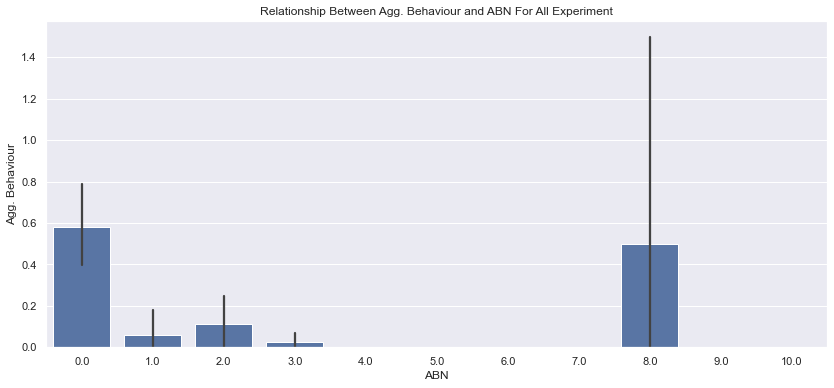

In [19]:
relation_bar(feature='Agg. Behaviour')

## Relationship betweeen Agg. Behaviour and DO

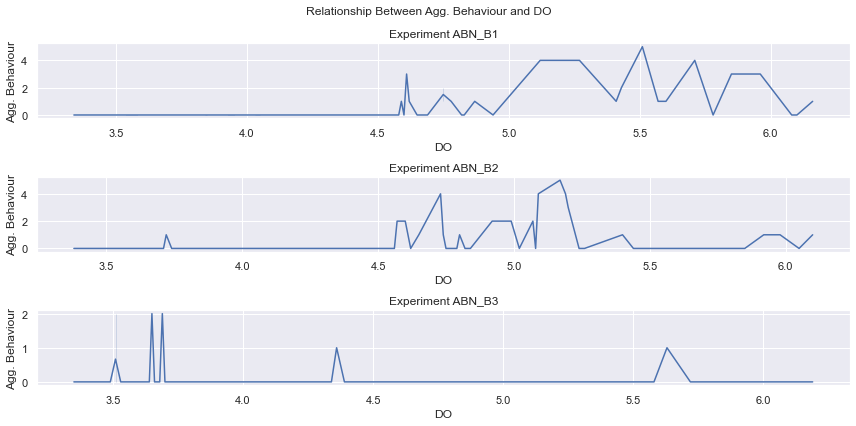

In [20]:
relation_line(feature='Agg. Behaviour')

## Relationship between Resting and Abnormal Level

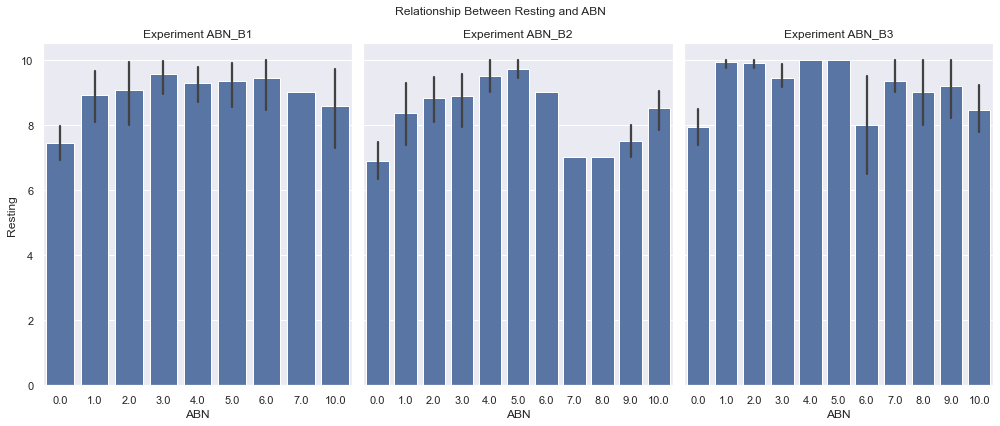

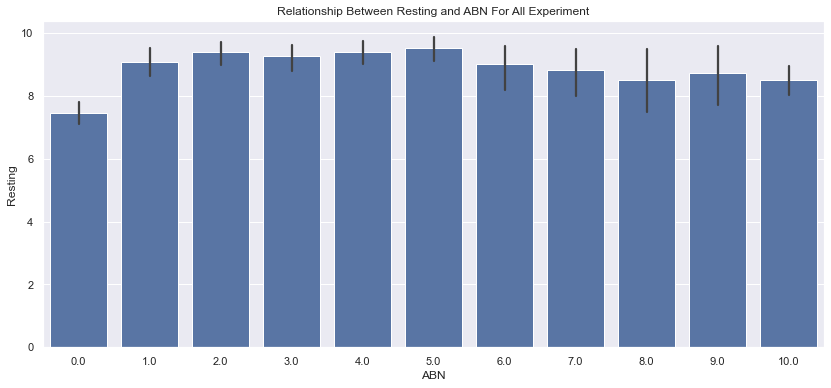

In [21]:
relation_bar(feature='Resting')

## Relationship between Resting and DO

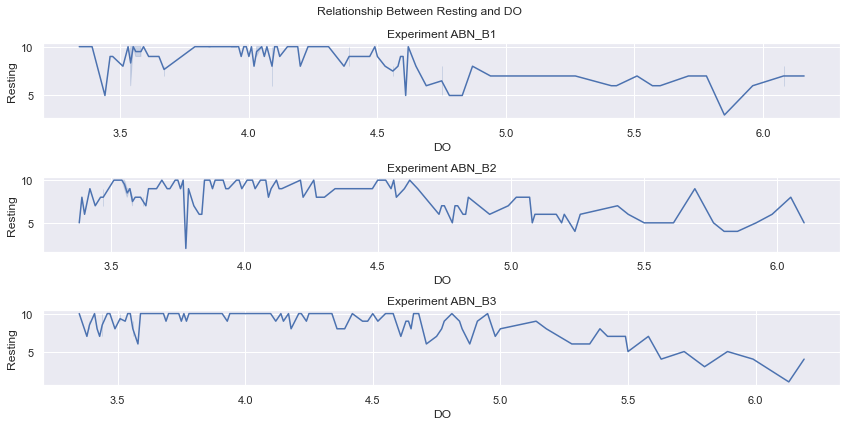

In [22]:
relation_line(feature='Resting')

## Relationship between Active and Abnormal Level

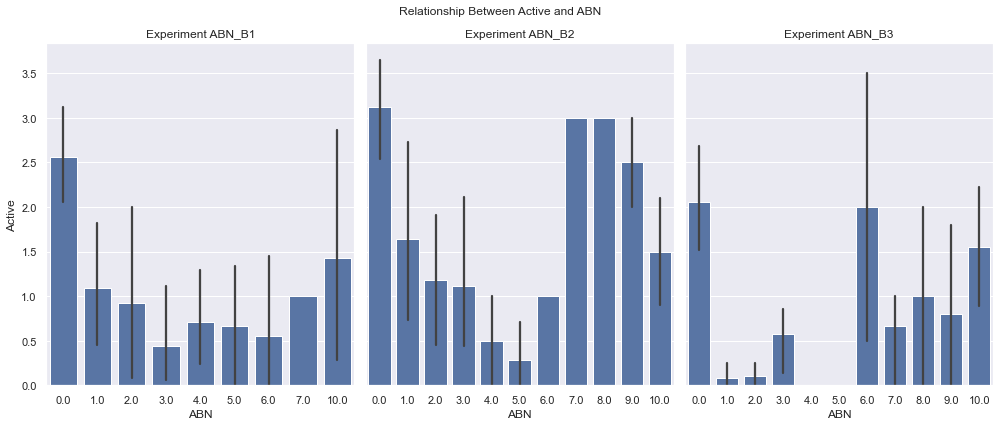

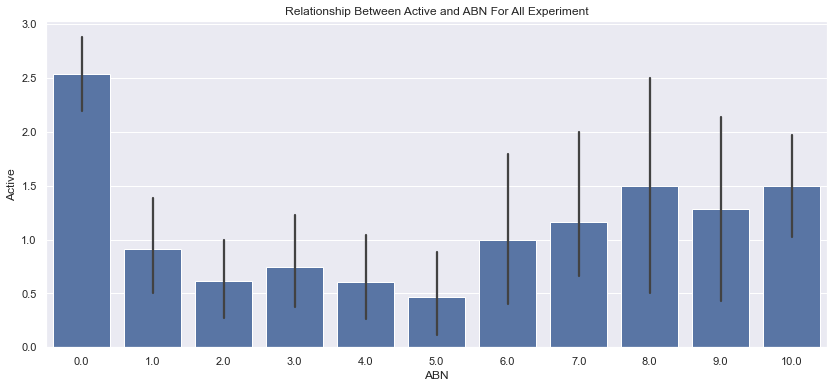

In [23]:
relation_bar(feature='Active')

## Relationship between Active and DO

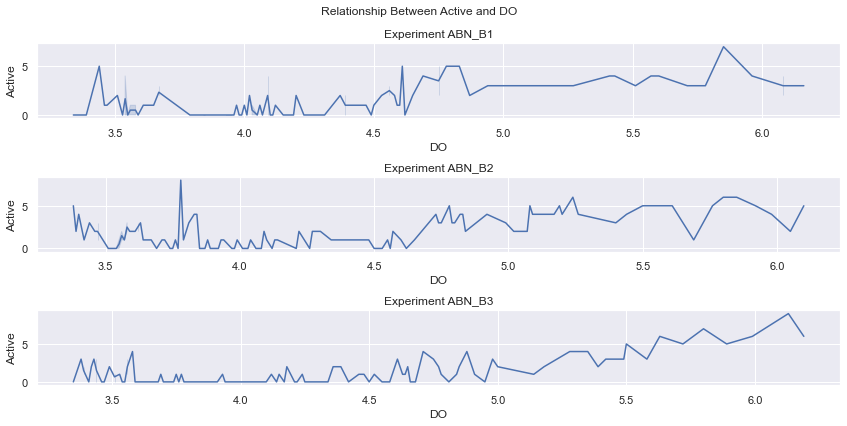

In [24]:
relation_line(feature='Active')

### Checking Distribution

In [25]:
conti = [
    'Hovering BTM', 
    'Hovering MID',
    'Hovering SUR', 
    'Fast Swim Btm', 
    'Fast Swim Mid', 
    'Fast Swim SUR',
    'Acc. Ver. MID', 
    'Acc. Ver. SUR', 
    'Turning', 
    'Agg. Behaviour',
    'Burst Swimming', 
    'Resting', 
    'Active', 
    'BTM', 
    'MID', 
    'SUR']

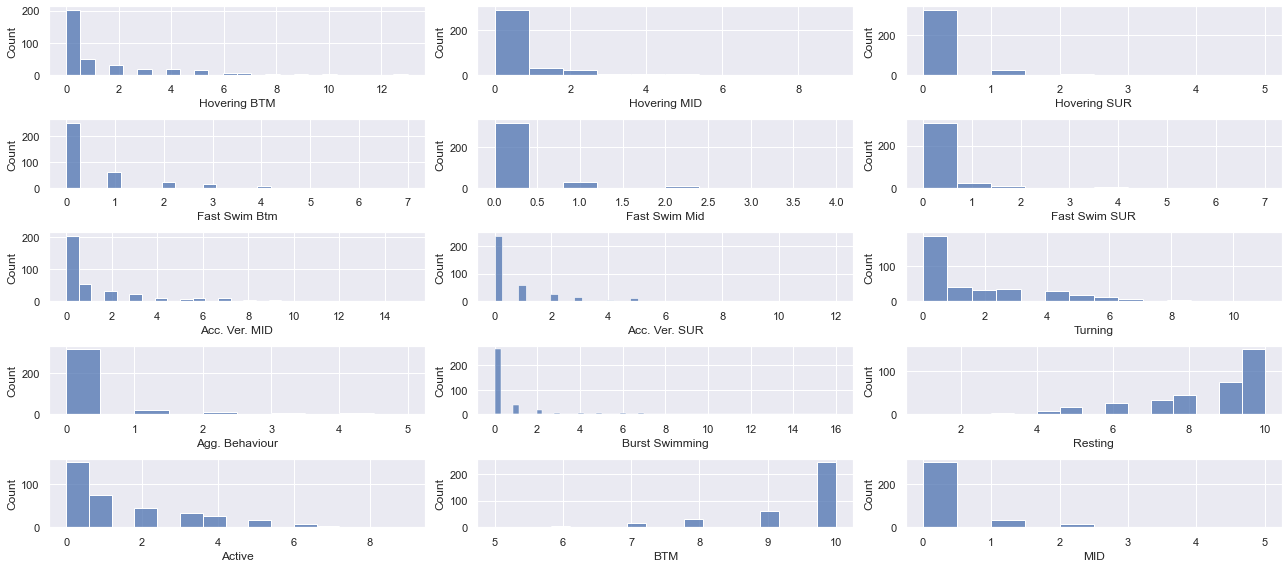

In [26]:
col = 3
row = len(conti) // col

fig, axes = plt.subplots(figsize=(18,8), nrows=row, ncols=col)
for idx, ax in enumerate(axes.flatten()):
    sns.histplot(df_all[conti[idx]], ax=ax)

plt.tight_layout()
plt.show()

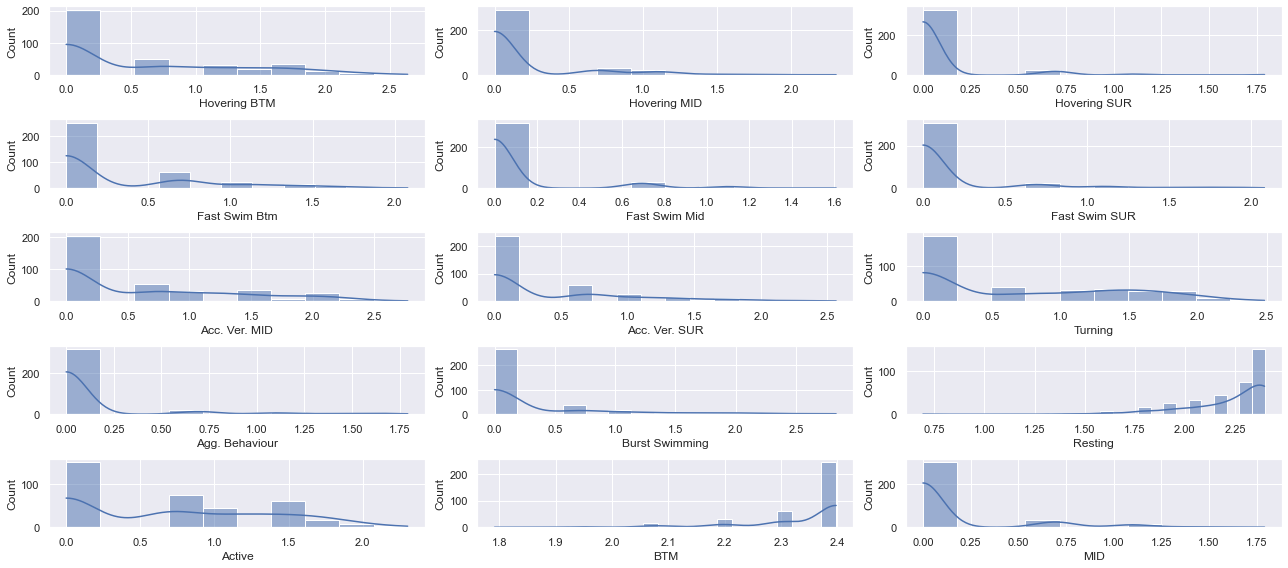

In [27]:
col = 3
row = len(conti) // col

fig, axes = plt.subplots(figsize=(18,8), nrows=row, ncols=col)
for idx, ax in enumerate(axes.flatten()):
    new_col = df_all[conti[idx]].apply(lambda x: np.log1p(x))
    sns.histplot(new_col, kde=True, ax=ax)

plt.tight_layout()
plt.show()

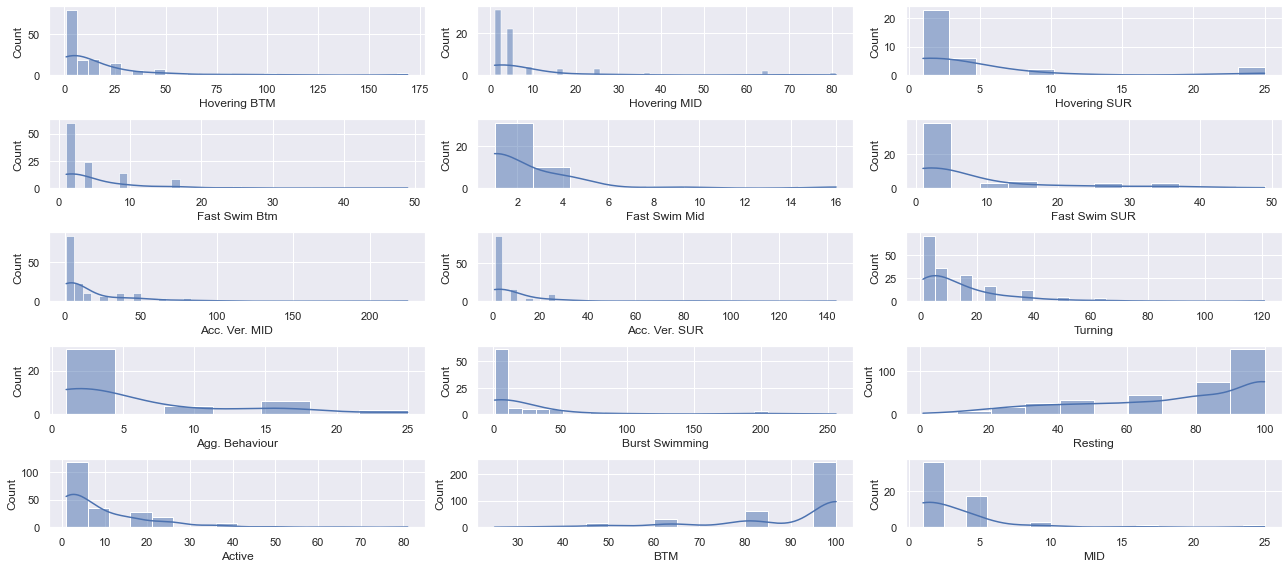

In [28]:
col = 3
row = len(conti) // col

fig, axes = plt.subplots(figsize=(18,8), nrows=row, ncols=col)
for idx, ax in enumerate(axes.flatten()):
    new_col = df_all[conti[idx]].apply(lambda x: np.square(x) if x != 0 else np.nan)
    sns.histplot(new_col, kde=True, ax=ax)

plt.tight_layout()
plt.show()

In [29]:
# Reset theme
sns.reset_orig()

# Feature Selection On All Batch Experiment

In [30]:
df = df_all.copy()
df = df.dropna()
df.head()

,time_start,time_ end,DO,Hovering BTM,Hovering MID,Hovering SUR,Fast Swim Btm,Fast Swim Mid,Fast Swim SUR,Acc. Ver. MID,...,Burst Swimming,Resting,Active,BTM,MID,SUR,N,ABN,ABN%,experiment
0,00:00:00,00:01:00,6.16,3.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,7.0,3.0,10.0,0.0,0.0,10.0,0.0,0.0,ABN_B1
1,00:01:00,00:02:00,6.10,2.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,7.0,3.0,10.0,0.0,0.0,10.0,0.0,0.0,ABN_B1
2,00:02:00,00:03:00,6.08,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,8.0,2.0,10.0,0.0,0.0,10.0,0.0,0.0,ABN_B1
3,00:03:00,00:04:00,6.08,5.0,0.0,0.0,4.0,0.0,0.0,2.0,...,0.0,6.0,4.0,9.0,1.0,0.0,10.0,0.0,0.0,ABN_B1
4,00:04:00,00:05:00,5.96,6.0,0.0,0.0,4.0,0.0,0.0,1.0,...,0.0,6.0,4.0,9.0,1.0,0.0,10.0,0.0,0.0,ABN_B1


In [31]:
# Describe the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DO,360.0,4.249861,0.706614,3.34,3.6875,4.05,4.6425,6.19
Hovering BTM,360.0,1.400000,2.270312,0.00,0.0000,0.00,2.0000,13.00
Hovering MID,360.0,0.402778,1.137604,0.00,0.0000,0.00,0.0000,9.00
Hovering SUR,360.0,0.155556,0.604737,0.00,0.0000,0.00,0.0000,5.00
Fast Swim Btm,360.0,0.569444,1.092216,0.00,0.0000,0.00,1.0000,7.00
Fast Swim Mid,360.0,0.161111,0.491305,0.00,0.0000,0.00,0.0000,4.00
Fast Swim SUR,360.0,0.319444,1.001759,0.00,0.0000,0.00,0.0000,7.00
Acc. Ver. MID,360.0,1.400000,2.322471,0.00,0.0000,0.00,2.0000,15.00
Acc. Ver. SUR,360.0,0.813889,1.659388,0.00,0.0000,0.00,1.0000,12.00
Turning,360.0,1.550000,2.089302,0.00,0.0000,0.00,3.0000,11.00


In [32]:
# Column to drop
columns = ['time_start', 'time_ end', 'DO', 'N', 'ABN', 'ABN%', 'experiment']

# Feature
X = df.drop(columns=columns)

# Label
y = df['ABN']

In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

results = []

# Iterate using from one feature to all feature
for i in range(len(X_train.columns)):
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
        input_features=X_train.columns
    )

    # Make predictions
    y_pred = pipeline.predict(X_test)

    result = {
        'data_batch': f"ABN_123",
        'number_feature': i+1,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=True), 
        'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=True),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=True),
        'recall_level_10': recall_level_10(y_test, y_pred)
    }
    

    # Message
    print(f"\n--- Inspecting Experiment Batch 123 ---")
    print(f"Selected feature: {sel_feat}")
    print(f"--- Results --- \n--- Using {i+1} feature ---")
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))
    
    results.append(result)

results = pd.DataFrame(results)


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR']
--- Results --- 
--- Using 1 feature ---
              precision    recall  f1-score   support

         0.0       0.41      1.00      0.58        39
         1.0       1.00      0.00      0.00        10
        10.0       1.00      0.00      0.00        13
         2.0       1.00      0.00      0.00        13
         3.0       1.00      0.00      0.00         7
         4.0       1.00      0.00      0.00         5
         5.0       1.00      0.00      0.00         5
         6.0       1.00      0.00      0.00         2
         7.0       1.00      0.00      0.00         1
         8.0       1.00      0.00      0.00         2
         9.0       0.50      0.55      0.52        11

    accuracy                           0.42       108
   macro avg       0.90      0.14      0.10       108
weighted avg       0.73      0.42      0.26       108


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swi

In [34]:
X_train.describe()

,Hovering BTM,Hovering MID,Hovering SUR,Fast Swim Btm,Fast Swim Mid,Fast Swim SUR,Acc. Ver. MID,Acc. Ver. SUR,Turning,Agg. Behaviour,Burst Swimming,Resting,Active,BTM,MID,SUR
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.456349,0.416667,0.138889,0.611111,0.194444,0.380952,1.428571,0.876984,1.472222,0.257937,1.130952,8.468254,1.531746,9.432540,0.261905,0.305556
std,2.345225,1.166002,0.446941,1.177290,0.541034,1.135148,2.324059,1.799941,2.051921,0.828367,2.741651,1.812689,1.812689,0.956948,0.699215,0.660412
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,9.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,10.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,3.000000,0.000000,1.000000,10.000000,3.000000,10.000000,0.000000,0.000000
max,13.000000,9.000000,3.000000,7.000000,4.000000,7.000000,15.000000,12.000000,11.000000,5.000000,16.000000,10.000000,9.000000,10.000000,5.000000,3.000000


In [35]:
print("Based on the results below:")
for idx, scoring in enumerate(['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'recall_level_10']):
    num_feature = results.loc[results[scoring].idxmax()]['number_feature']
    print(f"{idx+1}. The best score for {scoring} is {num_feature} features")

Based on the results below:
1. The best score for accuracy is 7 features
2. The best score for precision_weighted is 1 features
3. The best score for recall_weighted is 7 features
4. The best score for f1_weighted is 15 features
5. The best score for recall_level_10 is 12 features


In [36]:
results

,data_batch,number_feature,accuracy,precision_weighted,recall_weighted,f1_weighted,recall_level_10
0,ABN_123,1,0.416667,0.734664,0.416667,0.261782,0.000000
1,ABN_123,2,0.462963,0.727443,0.462963,0.365401,0.000000
2,ABN_123,3,0.453704,0.707262,0.453704,0.350455,0.000000
3,ABN_123,4,0.500000,0.668467,0.500000,0.413994,0.538462
4,ABN_123,5,0.444444,0.557267,0.444444,0.424682,0.076923
5,ABN_123,6,0.509259,0.626641,0.509259,0.471128,0.615385
6,ABN_123,7,0.518519,0.546433,0.518519,0.583587,0.615385
7,ABN_123,8,0.518519,0.546433,0.518519,0.583587,0.615385
8,ABN_123,9,0.481481,0.502832,0.481481,0.549684,0.384615
9,ABN_123,10,0.500000,0.513506,0.500000,0.562909,0.538462


However, how does this machine learning approach will help in hybrid grouper cultivation? Therefore, we need to change this approach for early alert system abnormalities detection

# Early Detection Application

To make this as an early detection system, we need to mark or consider how much threshold we accept before triggering the alert system. For now, lets take 50% as our threshold

In [37]:
df_bin = df_all.copy()

# Threshold
ABN_THRESHOLD = 5

# Early detection system will consider the tank abnormal above the thershold set
df_bin['ABN_bin'] = df_bin['ABN'].apply(lambda x: 1 if x > ABN_THRESHOLD else 0)

# Inspect data from index 100 to 110
df_bin[100:110]

,time_start,time_ end,DO,Hovering BTM,Hovering MID,Hovering SUR,Fast Swim Btm,Fast Swim Mid,Fast Swim SUR,Acc. Ver. MID,...,Resting,Active,BTM,MID,SUR,N,ABN,ABN%,experiment,ABN_bin
100,01:40:00,01:41:00,3.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,0.0,0.0,6.0,4.0,40.0,ABN_B1,0
101,01:41:00,01:42:00,3.57,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,9.0,1.0,10.0,0.0,0.0,3.0,7.0,70.0,ABN_B1,1
102,01:42:00,01:43:00,3.56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,9.0,1.0,10.0,0.0,0.0,8.0,2.0,20.0,ABN_B1,0
103,01:43:00,01:44:00,3.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,0.0,0.0,8.0,2.0,20.0,ABN_B1,0
104,01:44:00,01:45:00,3.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,0.0,0.0,8.0,2.0,20.0,ABN_B1,0
105,01:45:00,01:46:00,3.55,0.0,0.0,0.0,0.0,2.0,0.0,1.0,...,10.0,0.0,10.0,0.0,0.0,8.0,2.0,20.0,ABN_B1,0
106,01:46:00,01:47:00,3.54,0.0,0.0,0.0,0.0,1.0,3.0,0.0,...,9.0,1.0,9.0,0.0,1.0,7.0,3.0,30.0,ABN_B1,0
107,01:47:00,01:48:00,3.54,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,6.0,4.0,6.0,0.0,4.0,4.0,6.0,60.0,ABN_B1,1
108,01:48:00,01:49:00,3.54,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,10.0,0.0,10.0,0.0,0.0,4.0,6.0,60.0,ABN_B1,1
109,01:49:00,01:50:00,3.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,10.0,0.0,0.0,6.0,4.0,40.0,ABN_B1,0


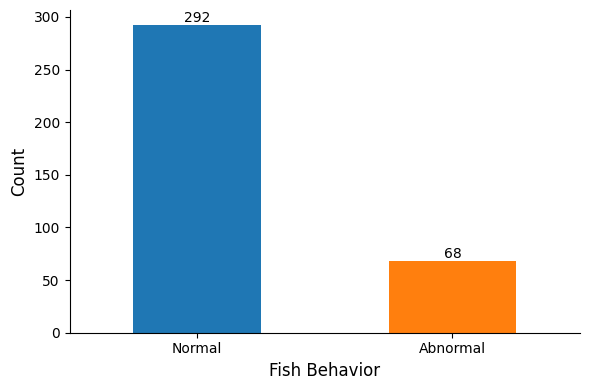

In [38]:
# Count the values in the 'ABN_bin' column
count_data = df_bin['ABN_bin'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(6, 4))
ax = count_data.plot(kind='bar', color=['C0', 'C1'])

# Add value labels on top of each bar
for i, v in enumerate(count_data):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

# Customize x-axis labels and title
ax.set_xticklabels(['Normal', 'Abnormal'], rotation=0)
ax.set_xlabel('Fish Behavior', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Add a title
# plt.title('Distribution of Fish Behavior', fontsize=14)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [39]:
# Drop NAN
df_bin = df_bin.dropna()

# Columns to drop
columns = ['time_start', 'time_ end', 'DO', 'N', 'ABN', 'ABN%', 'experiment', 'ABN_bin']

# Split to feature and label
X = df_bin.drop(columns=columns)
y = df_bin['ABN_bin']

# Feature Selection Without Feature Engineering

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

results = []

# Iterate using from one feature to all feature
for i in range(len(X_train.columns)):
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    sel_feat = pipeline.named_steps['feature_selection'].get_feature_names_out(
        input_features=X_train.columns
    )

    # Make predictions
    y_pred = pipeline.predict(X_test)

    result = {
        'data_batch': f"ABN_123",
        'number_feature': i+1,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred), 
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
    }
    

    # Message
    print(f"\n--- Inspecting Experiment Batch 123 ---")
    print(f"Selected feature: {sel_feat}")
    print(f"--- Results --- \n--- Using {i+1} feature ---")
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))
    
    results.append(result)

results = pd.DataFrame(results)


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR']
--- Results --- 
--- Using 1 feature ---
              precision    recall  f1-score   support

           0       0.85      0.99      0.92        88
           1       0.83      0.25      0.38        20

    accuracy                           0.85       108
   macro avg       0.84      0.62      0.65       108
weighted avg       0.85      0.85      0.82       108


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR' 'SUR']
--- Results --- 
--- Using 2 feature ---
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        88
           1       0.78      0.35      0.48        20

    accuracy                           0.86       108
   macro avg       0.82      0.66      0.70       108
weighted avg       0.85      0.86      0.84       108


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR' 'Acc. Ver. SUR' 'SUR']
--- R

In [41]:
print("Based on the results:")
for idx, scoring in enumerate(['accuracy', 'precision', 'recall', 'f1']):
    num_feature = results.loc[results[scoring].idxmax()]['number_feature']
    print(f"{idx+1}. The best score for {scoring} is {num_feature} features")

Based on the results:
1. The best score for accuracy is 7 features
2. The best score for precision is 1 features
3. The best score for recall is 7 features
4. The best score for f1 is 7 features


# Model Selection with Feature Selection

In [42]:
# Model selection
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'Gaussian': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE)
}

results = []

# Run average scoring for each model
for name, model in models.items():
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', model)
    ])

    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=RANDOM_STATE)

    result = {
        'model': name
    }

    for scoring in ['accuracy', 'precision', 'recall', 'f1']:
        scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
        result[scoring] = np.mean(scores)

    results.append(result)

results = pd.DataFrame(results)

In [43]:
results.sort_values('f1', ascending=False)

,model,accuracy,precision,recall,f1
5,Gaussian,0.857407,0.687007,0.595758,0.633677
4,KNN,0.859259,0.841858,0.441616,0.561431
6,Gradient Boosting,0.840741,0.714590,0.422414,0.516900
2,Random Forest,0.835185,0.686068,0.422081,0.509341
7,AdaBoost,0.833333,0.682906,0.411731,0.496416
0,Logistic Regression,0.846296,0.839048,0.340084,0.468838
3,Support Vector Machine,0.844444,0.862338,0.329271,0.459791
1,Decision Tree,0.805556,0.578846,0.335212,0.417782


In [44]:
def graph_xmodel_performance(results, x_axis='model', x_labels='Models'):
    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 8))

    # Set width of bars
    barWidth = 0.2

    # Set positions of the bars on X axis
    r1 = np.arange(len(results))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Create bars
    bars1 = ax.bar(r1, results['accuracy']*100, width=barWidth, label='Accuracy')
    bars2 = ax.bar(r2, results['precision']*100, width=barWidth, label='Precision')
    bars3 = ax.bar(r3, results['recall']*100, width=barWidth, label='Recall')
    bars4 = ax.bar(r4, results['f1']*100, width=barWidth, label='F1')

    # Function to add value labels
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', rotation=0, fontsize=8)

    # Add value labels to each set of bars
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    add_value_labels(bars4)

    # Add labels and title
    ax.set_xlabel(x_labels)
    ax.set_ylabel('Scores')
    # ax.set_title('Model Performance Comparison')
    ax.set_xticks([r + barWidth*1.5 for r in range(len(results))])
    ax.set_xticklabels(results[x_axis], rotation=45, ha='right')

    # Create legend
    ax.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

def graph_ymodel_performance(results, y_axis='model', y_labels='Models'):
    # Set up the plot
    fig, ax = plt.subplots(figsize=(14, 10))  # Increased width to accommodate legend

    # Set height of bars
    barHeight = 0.2

    # Set positions of the bars on Y axis
    r1 = np.arange(len(results))
    r2 = [y + barHeight for y in r1]
    r3 = [y + barHeight for y in r2]
    r4 = [y + barHeight for y in r3]

    # Create bars
    bars1 = ax.barh(r1, results['accuracy']*100, height=barHeight, label='Accuracy')
    bars2 = ax.barh(r2, results['precision']*100, height=barHeight, label='Precision')
    bars3 = ax.barh(r3, results['recall']*100, height=barHeight, label='Recall')
    bars4 = ax.barh(r4, results['f1']*100, height=barHeight, label='F1')

    # Function to add value labels
    def add_value_labels(bars):
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
                    f'{width:.2f}',
                    ha='left', va='center', fontsize=8)

    # Add value labels to each set of bars
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    add_value_labels(bars4)

    # Add labels and title
    ax.set_ylabel(y_labels)
    ax.set_xlabel('Scores')
    ax.set_yticks([r + barHeight*1.5 for r in range(len(results))])
    ax.set_yticklabels(results[y_axis])

    # Create legend outside the plot
    ax.legend(loc='upper right', ncol=4)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

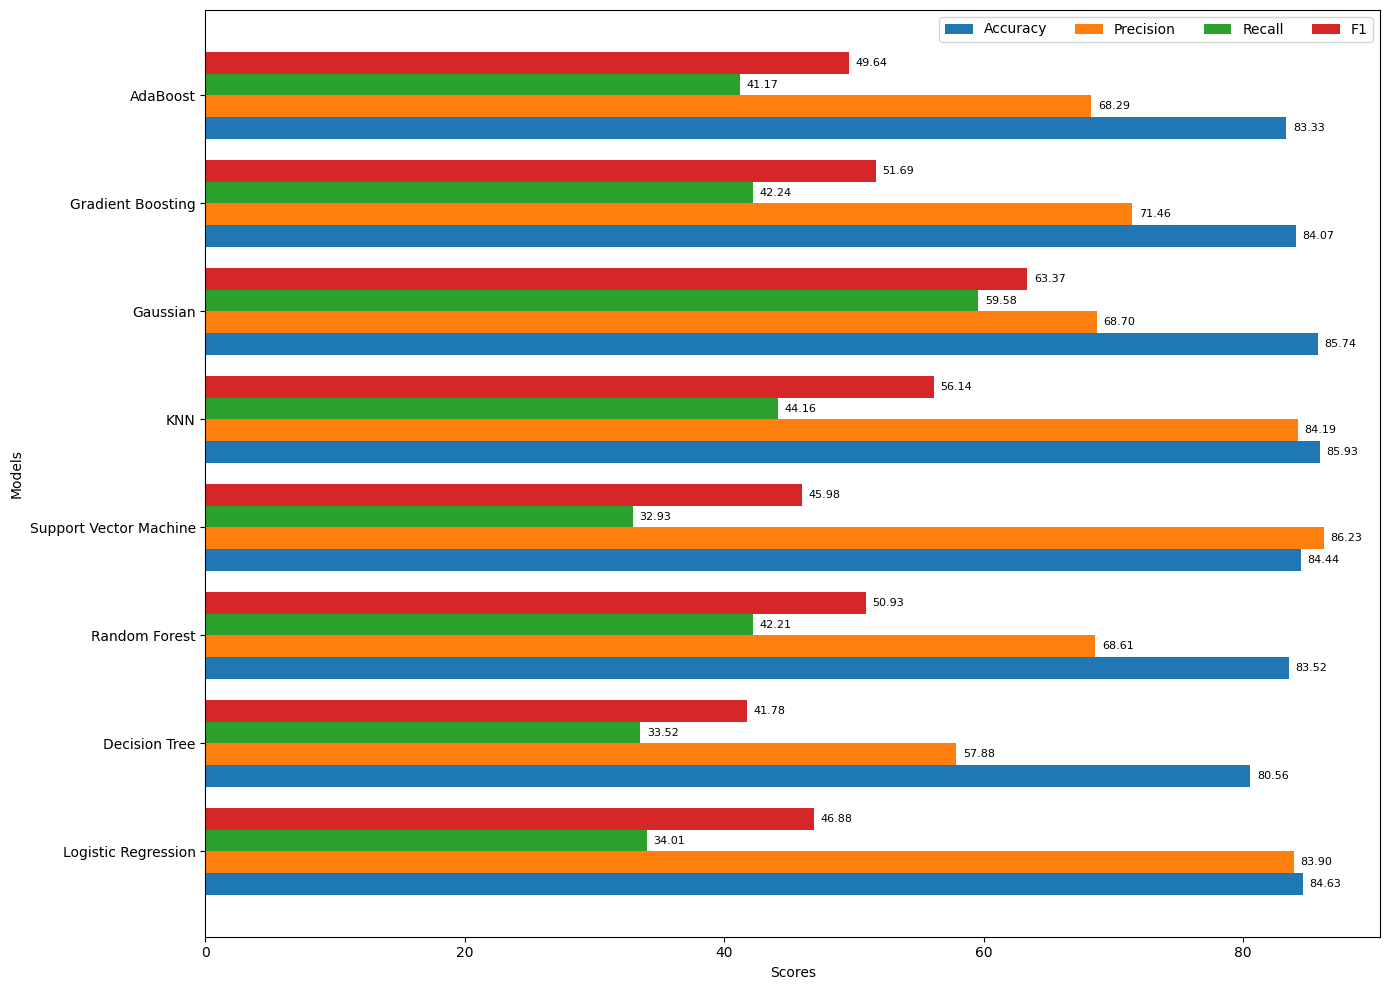

In [45]:
graph_ymodel_performance(results)

In [47]:
clf = models['Gaussian']

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('classifier', clf)
])
    
# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))


              precision    recall  f1-score   support

           0       0.93      0.92      0.93        88
           1       0.67      0.70      0.68        20

    accuracy                           0.88       108
   macro avg       0.80      0.81      0.80       108
weighted avg       0.88      0.88      0.88       108



In [48]:
{
    'accuracy': accuracy_score(y_test, y_pred),
    'precision_weighted': precision_score(y_test, y_pred, zero_division=True), 
    'recall_weighted': recall_score(y_test, y_pred, zero_division=True),
    'f1_weighted': f1_score(y_test, y_pred, zero_division=True),
}

{'accuracy': 0.8796296296296297,
 'precision_weighted': 0.6666666666666666,
 'recall_weighted': 0.7,
 'f1_weighted': 0.6829268292682926}

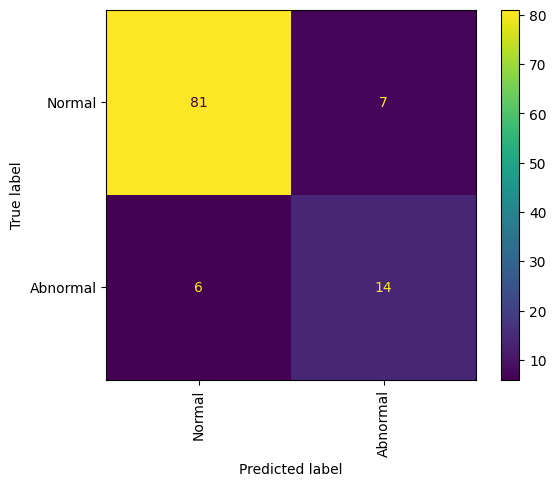

In [49]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', display_labels=['Normal', 'Abnormal'])
plt.show()

In [50]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([88, 20], dtype=int64))

### Note
Remember that the data is imbalanced, therefore there are several technique that we can use such as Cost Sensitive, Ensemble Method or Data Resampling

C:\Users\isaac\AppData\Local\Temp\ipykernel_1956\2554740715.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['Normal', 'Abnormal'])


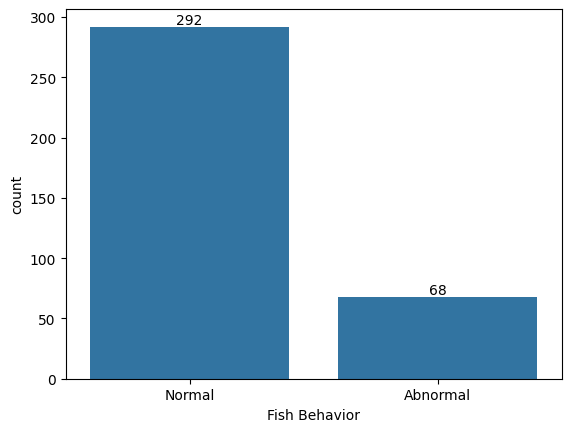

In [51]:
ax = sns.countplot(df_bin, x='ABN_bin', legend=False)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_xticklabels(labels=['Normal', 'Abnormal'])
ax.set_xlabel('Fish Behavior')
plt.show()

### Cost Sensitive

In [52]:
results = []
for w in np.arange(0.1, 1.1, 0.1):
    clf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight={0:w})

    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', clf)
    ])
        
    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Message
    print(f'\n--- Weight 0: {w} ---')
    print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

    result = {
        'weight': w
    }

    for scoring in ['accuracy', 'precision', 'recall', 'f1']:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
        result[scoring] = np.mean(scores)

    results.append(result)

results = pd.DataFrame(results)


--- Weight 0: 0.1 ---
              precision    recall  f1-score   support

           0       0.87      0.68      0.76        88
           1       0.28      0.55      0.37        20

    accuracy                           0.66       108
   macro avg       0.58      0.62      0.57       108
weighted avg       0.76      0.66      0.69       108


--- Weight 0: 0.2 ---
              precision    recall  f1-score   support

           0       0.86      0.69      0.77        88
           1       0.27      0.50      0.35        20

    accuracy                           0.66       108
   macro avg       0.56      0.60      0.56       108
weighted avg       0.75      0.66      0.69       108


--- Weight 0: 0.30000000000000004 ---
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        88
           1       0.64      0.45      0.53        20

    accuracy                           0.85       108
   macro avg       0.76      0.70      0.72

In [53]:
results

,weight,accuracy,precision,recall,f1
0,0.1,0.653704,0.319450,0.556150,0.403040
1,0.2,0.785185,0.561338,0.420990,0.456146
2,0.3,0.829630,0.650968,0.408490,0.493470
3,0.4,0.831481,0.656307,0.430081,0.509466
4,0.5,0.835185,0.676068,0.430081,0.515209
5,0.6,0.833333,0.672353,0.417914,0.504784
6,0.7,0.835185,0.678889,0.430414,0.514053
7,0.8,0.833333,0.677296,0.422081,0.506442
8,0.9,0.833333,0.668413,0.429488,0.509333
9,1.0,0.835185,0.686068,0.422081,0.509341


### Ensemble Method

In [54]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [55]:
estimators = [
    ('rf', Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
    ])),
    ('dt', Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])),
    ('gnb', Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', GaussianNB())
    ]))
]

# Choose All
# estimators = []

# for name, model in models.items():
#     estimator = Pipeline([
#         ('scaler', StandardScaler()),
#         ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
#         ('classifier', model)
#     ])

#     estimators.append((name, estimator))

In [56]:
clf = StackingClassifier(estimators=estimators)

# Fit the pipeline
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Message
print(f'\n--- Weight 0: {w} ---')
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

result = {}
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
    result[scoring] = np.mean(scores)

pd.DataFrame(result, index=[0])


--- Weight 0: 1.0 ---
              precision    recall  f1-score   support

           0       0.89      0.97      0.92        88
           1       0.75      0.45      0.56        20

    accuracy                           0.87       108
   macro avg       0.82      0.71      0.74       108
weighted avg       0.86      0.87      0.86       108



,accuracy,precision,recall,f1
0,0.835185,0.686068,0.422081,0.509341


In [57]:
clf = VotingClassifier(estimators=estimators, voting='soft')

# Fit the pipeline
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Message
print(f'\n--- Weight 0: {w} ---')
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

result = {}
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
    result[scoring] = np.mean(scores)

pd.DataFrame(result, index=[0])


--- Weight 0: 1.0 ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.91        88
           1       0.60      0.45      0.51        20

    accuracy                           0.84       108
   macro avg       0.74      0.69      0.71       108
weighted avg       0.83      0.84      0.83       108



,accuracy,precision,recall,f1
0,0.835185,0.686068,0.422081,0.509341


### Random Oversampling

In [58]:
sampling_results = {}

Original Data Number: 252
Resample Data Number: 408


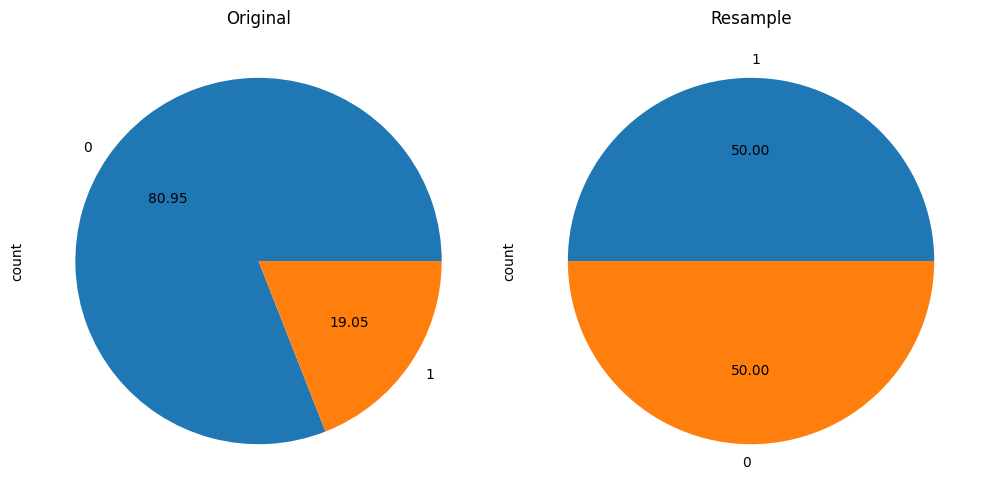

In [59]:
# Random Oversampling
ros = RandomOverSampler(random_state=RANDOM_STATE)

# Resampling data
X_res, y_res = ros.fit_resample(X_train, y_train)

print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)

In [61]:
clf = models['Gaussian']

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('classifier', clf)
])

# Fit the pipeline
pipeline.fit(X_res, y_res)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        88
           1       0.64      0.70      0.67        20

    accuracy                           0.87       108
   macro avg       0.78      0.80      0.79       108
weighted avg       0.88      0.87      0.87       108



In [62]:
# Take recall average
steps = [
    ('ros_auto', RandomOverSampler(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('model', clf)
]

pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    print(f"The average scoring of {scoring}: {np.mean(scores)}")

The average scoring of accuracy: 0.8592592592592592
The average scoring of precision: 0.6330351130351132
The average scoring of recall: 0.6674603174603175
The average scoring of f1: 0.6389824826589533


### Random Undersampling

Original Data Number: 252
Resample Data Number: 96


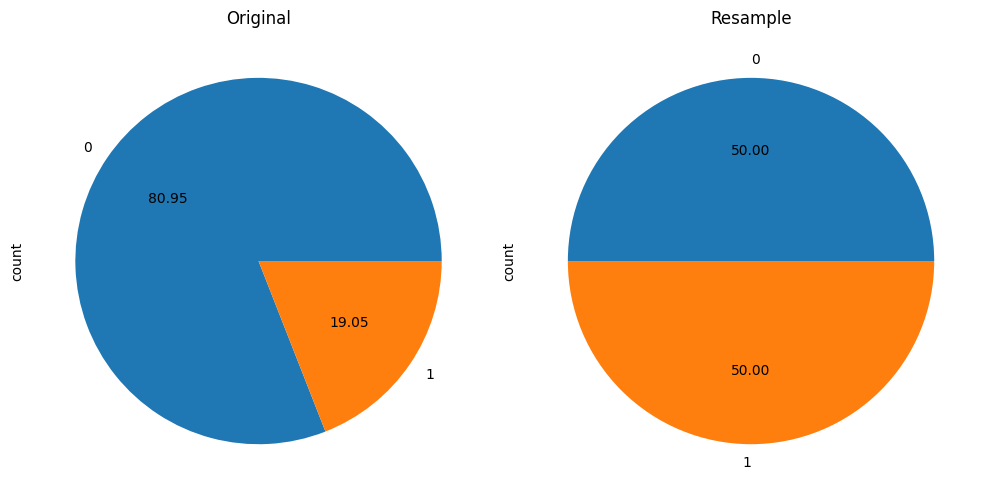

In [63]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)

# Resampling data
X_res, y_res = rus.fit_resample(X_train, y_train)

print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)

In [64]:
clf = models['Gaussian']

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('classifier', clf)
])

# Fit the pipeline
pipeline.fit(X_res, y_res)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        88
           1       0.50      0.75      0.60        20

    accuracy                           0.81       108
   macro avg       0.72      0.79      0.74       108
weighted avg       0.86      0.81      0.83       108



In [65]:
# Take recall average
steps = [
    ('rus_auto', RandomUnderSampler(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('model', clf)
]

pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    print(f"The average scoring of {scoring}: {np.mean(scores)}")

The average scoring of accuracy: 0.8175925925925926
The average scoring of precision: 0.5533658362334833
The average scoring of recall: 0.719047619047619
The average scoring of f1: 0.6055813147731307


### Custom Oversampling

Original Data Number: 252
Resample Data Number: 220


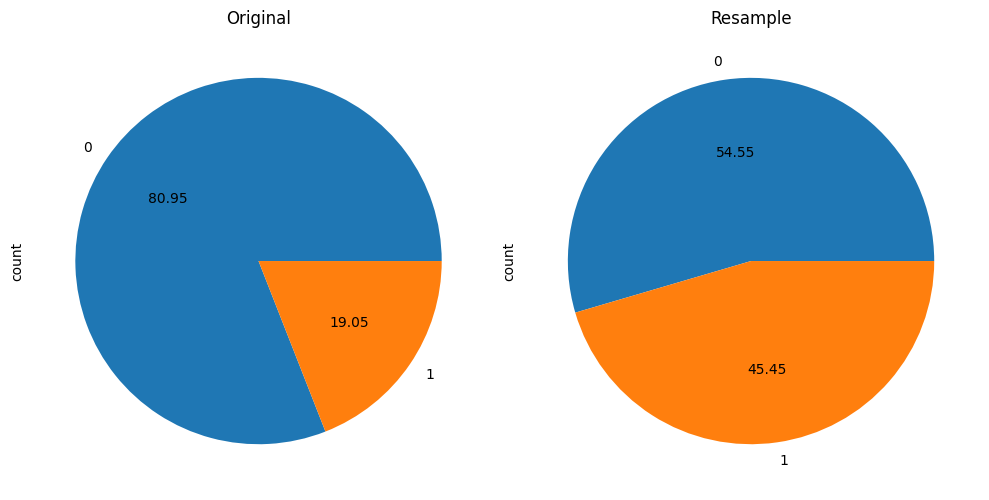

In [66]:
N_RESAMPLE = 20

df_res = df_bin.iloc[X_train.index, :].groupby('ABN').apply(
    lambda x: x.sample(N_RESAMPLE, replace=True, random_state=RANDOM_STATE)
).reset_index(drop=True)

# Split to feature and label
X_res = df_res.drop(columns=columns)
y_res = df_res['ABN_bin']

print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)

In [68]:
clf = models['Gaussian']

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('classifier', clf)
])

# Fit the pipeline
pipeline.fit(X_res, y_res)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

              precision    recall  f1-score   support

           0       0.95      0.65      0.77        88
           1       0.35      0.85      0.50        20

    accuracy                           0.69       108
   macro avg       0.65      0.75      0.64       108
weighted avg       0.84      0.69      0.72       108



In [69]:
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X_res, y_res, scoring=scoring, cv=cv, n_jobs=-1)
    print(f"The average scoring of {scoring}: {np.mean(scores)}")

The average scoring of accuracy: 0.6984848484848485
The average scoring of precision: 0.645229917141682
The average scoring of recall: 0.8699999999999998
The average scoring of f1: 0.7253677302300492


In [70]:
results = []
for sampling in np.arange(10, 60, 10):
    df_res = df_bin.iloc[X_train.index, :].groupby('ABN').apply(
        lambda x: x.sample(sampling, replace=True, random_state=RANDOM_STATE)
    ).reset_index(drop=True)

    # Split to feature and label
    X_res = df_res.drop(columns=columns)
    y_res = df_res['ABN_bin']

    # Fit the pipeline
    pipeline.fit(X_res, y_res)

    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

    result = {
        'number_sampling': sampling
    }

    for scoring in ['accuracy', 'precision', 'recall', 'f1']:
        scores = cross_val_score(pipeline, X_res, y_res, scoring=scoring, cv=cv, n_jobs=-1)
        result[scoring] = np.mean(scores)

    results.append(result)

results = pd.DataFrame(results)

In [71]:
results.sort_values('f1', ascending=False)

,number_sampling,accuracy,precision,recall,f1
2,30,0.703030,0.619330,0.920000,0.738597
3,40,0.700000,0.616302,0.918333,0.736522
4,50,0.703030,0.622541,0.896000,0.733690
1,20,0.698485,0.645230,0.870000,0.725368
0,10,0.672727,0.609193,0.906667,0.722271


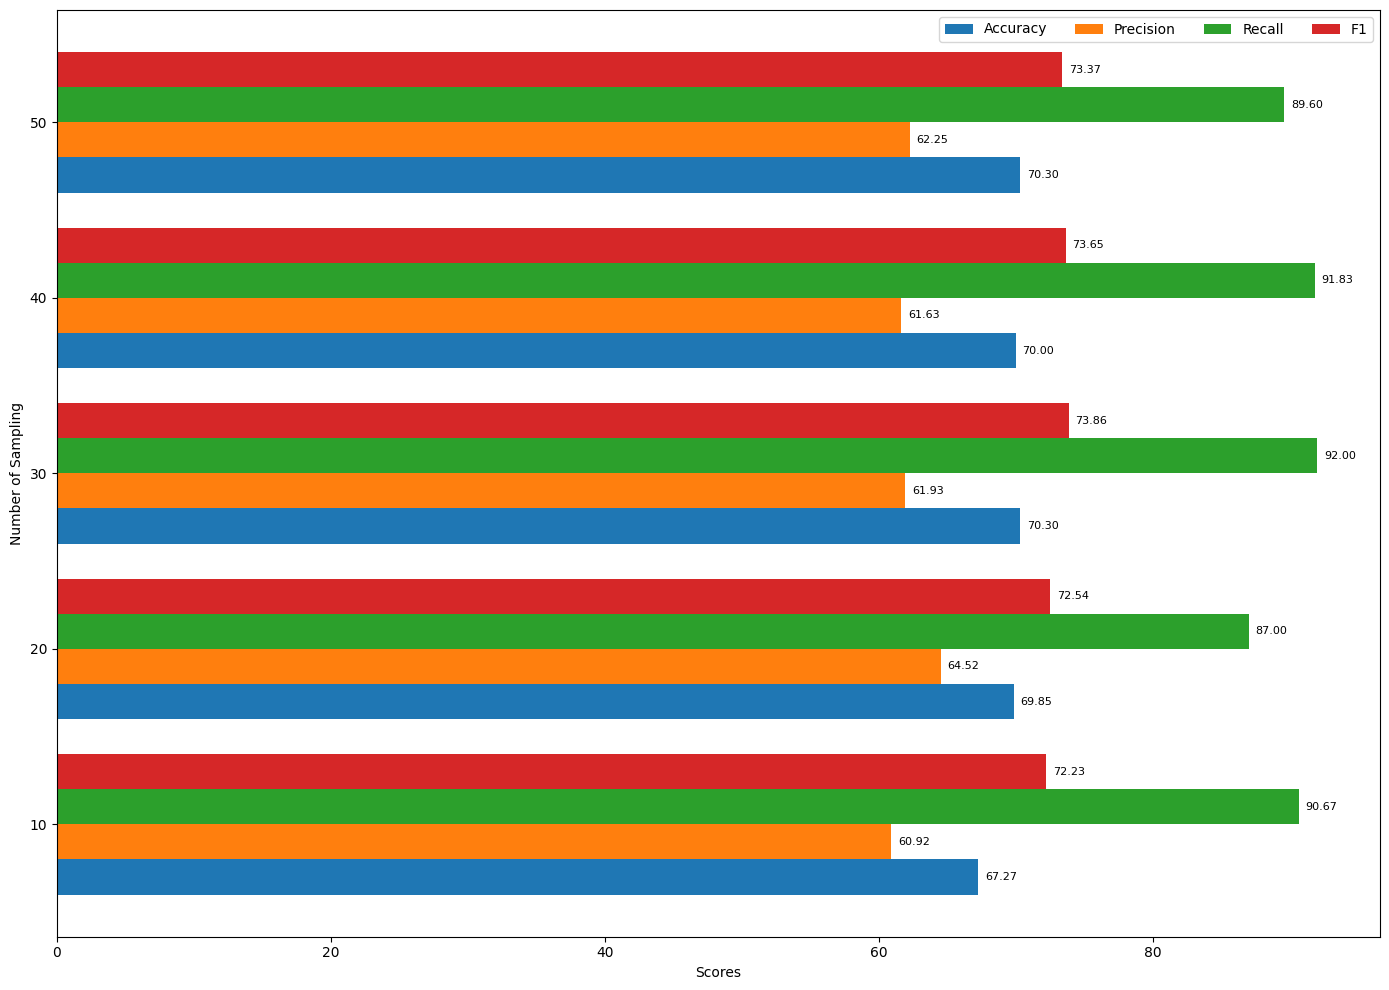

In [72]:
graph_ymodel_performance(results, y_axis='number_sampling', y_labels='Number of Sampling')

# Sampling + Feature Selection Experiment

In [74]:
results = []

clf = models['Gaussian']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

samplers = {
    'ROS': RandomOverSampler(random_state=RANDOM_STATE),
    'RUS': RandomUnderSampler(random_state=RANDOM_STATE),
    'SMOTE': SMOTE(random_state=RANDOM_STATE)
    }

for name, sampler in samplers.items():
    result = {
        'name': name
    }

    steps = [
        ('sampler', sampler),
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('model', clf)
    ]

    pipeline = Pipeline(steps=steps)


    for scoring in ['accuracy', 'precision', 'recall', 'f1']:
        scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        result[scoring] = np.mean(scores)
        print(f"The average scoring of {scoring}: {np.mean(scores)}")

    results.append(result)



N_RESAMPLE = 30

scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}
result = {
    'name': 'CS'
}

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    df_res = df_bin.iloc[train_idx, :].groupby('ABN').apply(
        lambda x: x.sample(N_RESAMPLE, replace=True, random_state=RANDOM_STATE)
    ).reset_index(drop=True)

    # Split to feature and label
    X_res = df_res.drop(columns=columns)
    y_res = df_res['ABN_bin']

    # Create the pipeline
    pipeline_cs = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
        ('classifier', clf)
    ])

    pipeline_cs.fit(X_res, y_res)

    Xr_test = df_bin.iloc[test_idx, :].drop(columns=columns)
    yr_test = df_bin.iloc[test_idx, :]['ABN_bin']

    y_pred = pipeline_cs.predict(Xr_test)
    
    scores['accuracy'].append(accuracy_score(yr_test, y_pred))
    scores['precision'].append(precision_score(yr_test, y_pred))
    scores['recall'].append(recall_score(yr_test, y_pred))
    scores['f1'].append(f1_score(yr_test, y_pred))

for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    result[scoring] = np.mean(scores[scoring])
    print(f"The average scoring of {scoring}: {np.mean(scores[scoring])}")

results.append(result)
results = pd.DataFrame(results)

The average scoring of accuracy: 0.8592592592592592
The average scoring of precision: 0.6330351130351132
The average scoring of recall: 0.6674603174603175
The average scoring of f1: 0.6389824826589533
The average scoring of accuracy: 0.8175925925925926
The average scoring of precision: 0.5533658362334833
The average scoring of recall: 0.719047619047619
The average scoring of f1: 0.6055813147731307
The average scoring of accuracy: 0.8499999999999999
The average scoring of precision: 0.600899470899471
The average scoring of recall: 0.680952380952381
The average scoring of f1: 0.6277720791420481
The average scoring of accuracy: 0.8212962962962963
The average scoring of precision: 0.5497510115157174
The average scoring of recall: 0.6563492063492065
The average scoring of f1: 0.5853604221715678


In [75]:
results

,name,accuracy,precision,recall,f1
0,ROS,0.859259,0.633035,0.667460,0.638982
1,RUS,0.817593,0.553366,0.719048,0.605581
2,SMOTE,0.850000,0.600899,0.680952,0.627772
3,CS,0.821296,0.549751,0.656349,0.585360


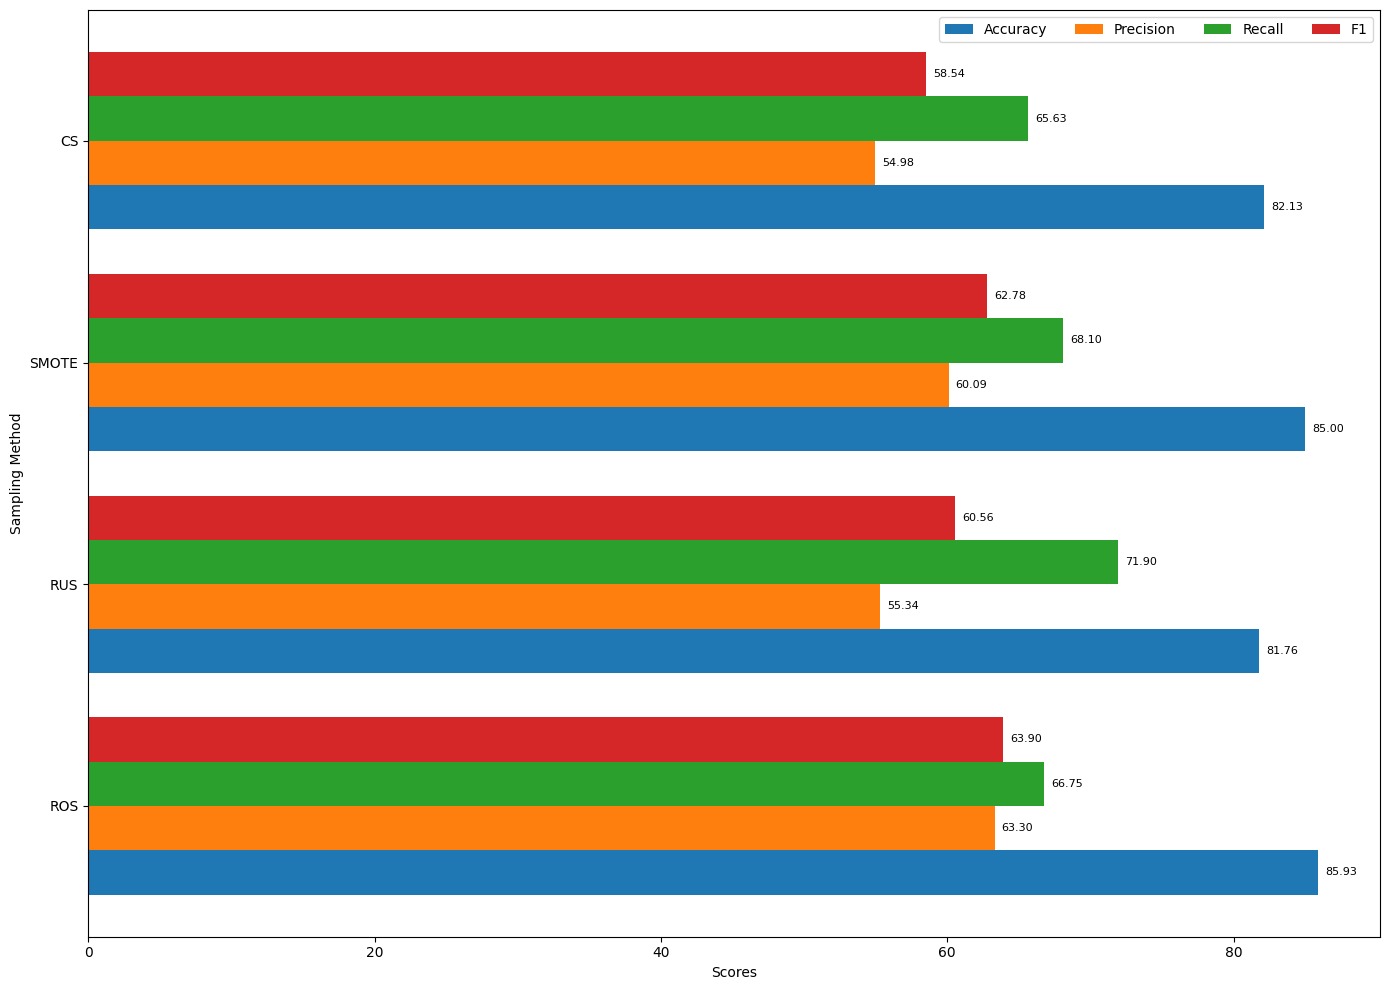

In [76]:
graph_ymodel_performance(results, y_axis='name', y_labels='Sampling Method')

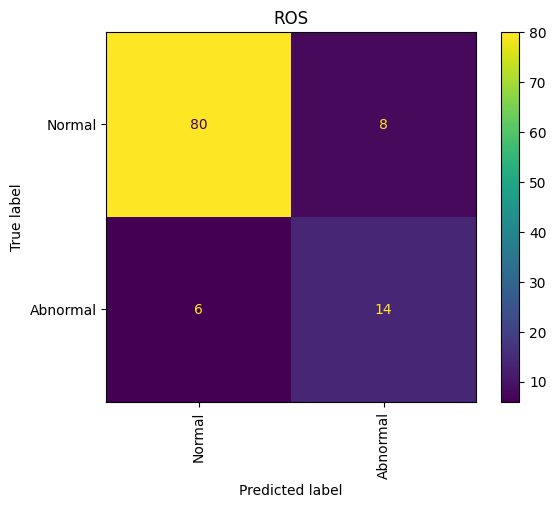

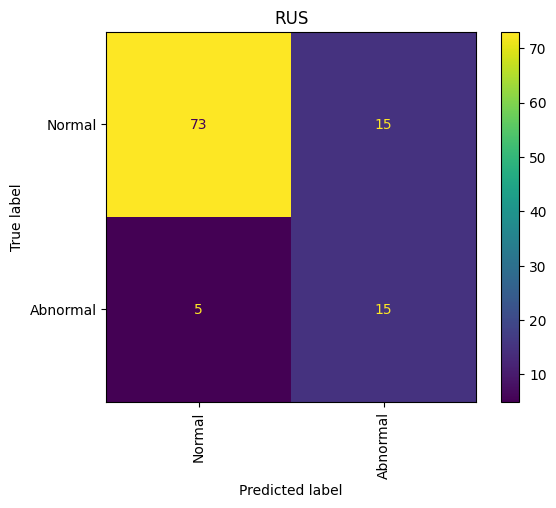

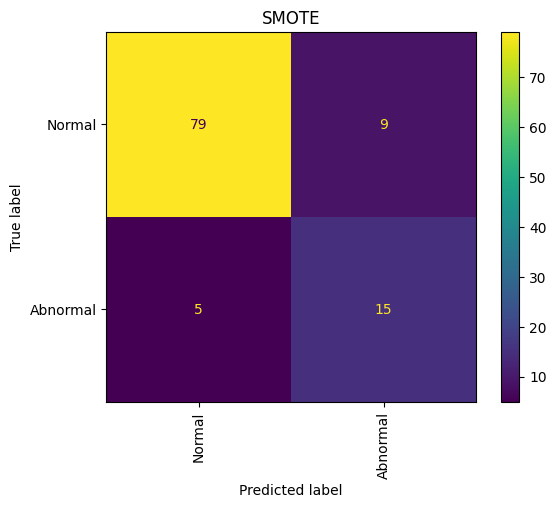

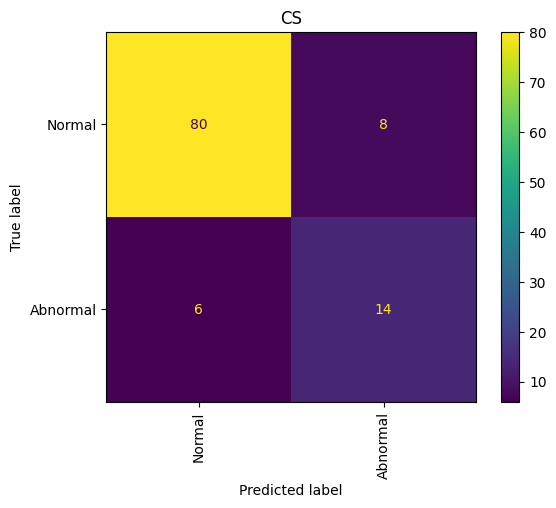

In [77]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=7)),
    ('classifier', clf)
])

for name, sampler in samplers.items():
    result = {
        'name': name
    }

    X_res, y_res = sampler.fit_resample(X_train, y_train)

    pipeline.fit(X_res, y_res)

    y_pred = pipeline.predict(X_test)

    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', display_labels=['Normal', 'Abnormal'])
    plt.title(name)
    plt.show()


# Custom sampler
df_res = df_bin.iloc[train_idx, :].groupby('ABN').apply(
    lambda x: x.sample(N_RESAMPLE, replace=True, random_state=RANDOM_STATE)
).reset_index(drop=True)

# Split to feature and label
X_res = df_res.drop(columns=columns)
y_res = df_res['ABN_bin']

pipeline.fit(X_res, y_res)

y_pred = pipeline.predict(X_test)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', display_labels=['Normal', 'Abnormal'])
plt.title('CS')
plt.show()

# Feature Engineering

In [78]:
fe_col = X.columns

def log_transform(df, columns):
    for col in columns:
        new_col = f"{col}_log10"
        df[new_col] = np.log1p(df[col])

    return df[columns]

def square_transform(df, columns):
    for col in columns:
        new_col = f"{col}_square"
        df[new_col] = np.square(df[col])

    return df[columns]

def pca_transform(df, columns):
    pca = PCA(random_state=RANDOM_STATE, n_components=2)
    compress = pca.fit_transform(df[columns])

    columns = []
    for i in range(2):
        col_name = f'PCA_{i}'
        df[col_name] = compress[:, i]
        
        columns.append(col_name)

    return df[columns] 

In [79]:
df_fe = df_bin.copy()
df_log = log_transform(df_fe, conti)
df_square = square_transform(df_fe, conti)
df_pca = pca_transform(df_fe, conti)

df_fe = pd.concat([df_fe, df_log, df_square], axis=1).dropna()

# Split to feature and label
X = df_fe.drop(columns=columns)
y = df_fe['ABN_bin']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [80]:
results = []

# Run average scoring for each model
for name, model in models.items():

    for i in range(len(X_train.columns)//2):
        clf = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=i+1)),
            ('classifier', model)
        ])

        # Fit model
        clf.fit(X_train, y_train)

        # Selected feature
        sel_feat = clf.named_steps['feature_selection'].get_feature_names_out(
            input_features=X_train.columns
        )

        # Model prediction
        y_pred = clf.predict(X_test)

        # Store results
        result = {
            'data_batch': f"ABN_123",
            'model': name,
            'number_feature': i+1,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred), 
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }

        print(f"\n--- Inspecting Experiment Batch 123 ---")
        print(f"Selected feature: {sel_feat}")
        print(f"--- Results --- \n--- Using {i+1} feature with {name}---")
        print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

        results.append(result)

results = pd.DataFrame(results)


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR_log10']
--- Results --- 
--- Using 1 feature with Logistic Regression---
              precision    recall  f1-score   support

           0       0.85      0.99      0.92        88
           1       0.83      0.25      0.38        20

    accuracy                           0.85       108
   macro avg       0.84      0.62      0.65       108
weighted avg       0.85      0.85      0.82       108


--- Inspecting Experiment Batch 123 ---
Selected feature: ['Fast Swim SUR_log10' 'Fast Swim SUR']
--- Results --- 
--- Using 2 feature with Logistic Regression---
              precision    recall  f1-score   support

           0       0.85      0.99      0.92        88
           1       0.83      0.25      0.38        20

    accuracy                           0.85       108
   macro avg       0.84      0.62      0.65       108
weighted avg       0.85      0.85      0.82       108


--- Inspecting Experiment Batch 1

In [81]:
print('Based on the results')
num_features = []
for idx, scoring in enumerate(['accuracy', 'precision', 'recall', 'f1']):
    num_feature = results.loc[results[scoring].idxmax()]['number_feature']
    model_name = results.loc[results[scoring].idxmax()]['model']

    score = results.loc[results[scoring].idxmax()][scoring]
    print(f"{idx+1}. The best score for {scoring} ({score:.4f}) is {num_feature} features using {model_name}")

    num_features.append(num_feature)

Based on the results
1. The best score for accuracy (0.9074) is 33 features using Support Vector Machine
2. The best score for precision (0.9091) is 21 features using Support Vector Machine
3. The best score for recall (0.7000) is 32 features using Gaussian
4. The best score for f1 (0.7368) is 32 features using Gaussian


In [82]:
# SVM Model
results[(
    (results['accuracy'] > 0.9)
    & (results['model'] == 'Support Vector Machine')
)]

,data_batch,model,number_feature,accuracy,precision,recall,f1
155,ABN_123,Support Vector Machine,33,0.907407,0.857143,0.6,0.705882
156,ABN_123,Support Vector Machine,34,0.907407,0.857143,0.6,0.705882
157,ABN_123,Support Vector Machine,35,0.907407,0.857143,0.6,0.705882


In [83]:
# remove duplicate
num_features = list(dict.fromkeys(num_features))

### Sampling + Feature Selection + Feature Engneering

--- Gaussian with 33 features


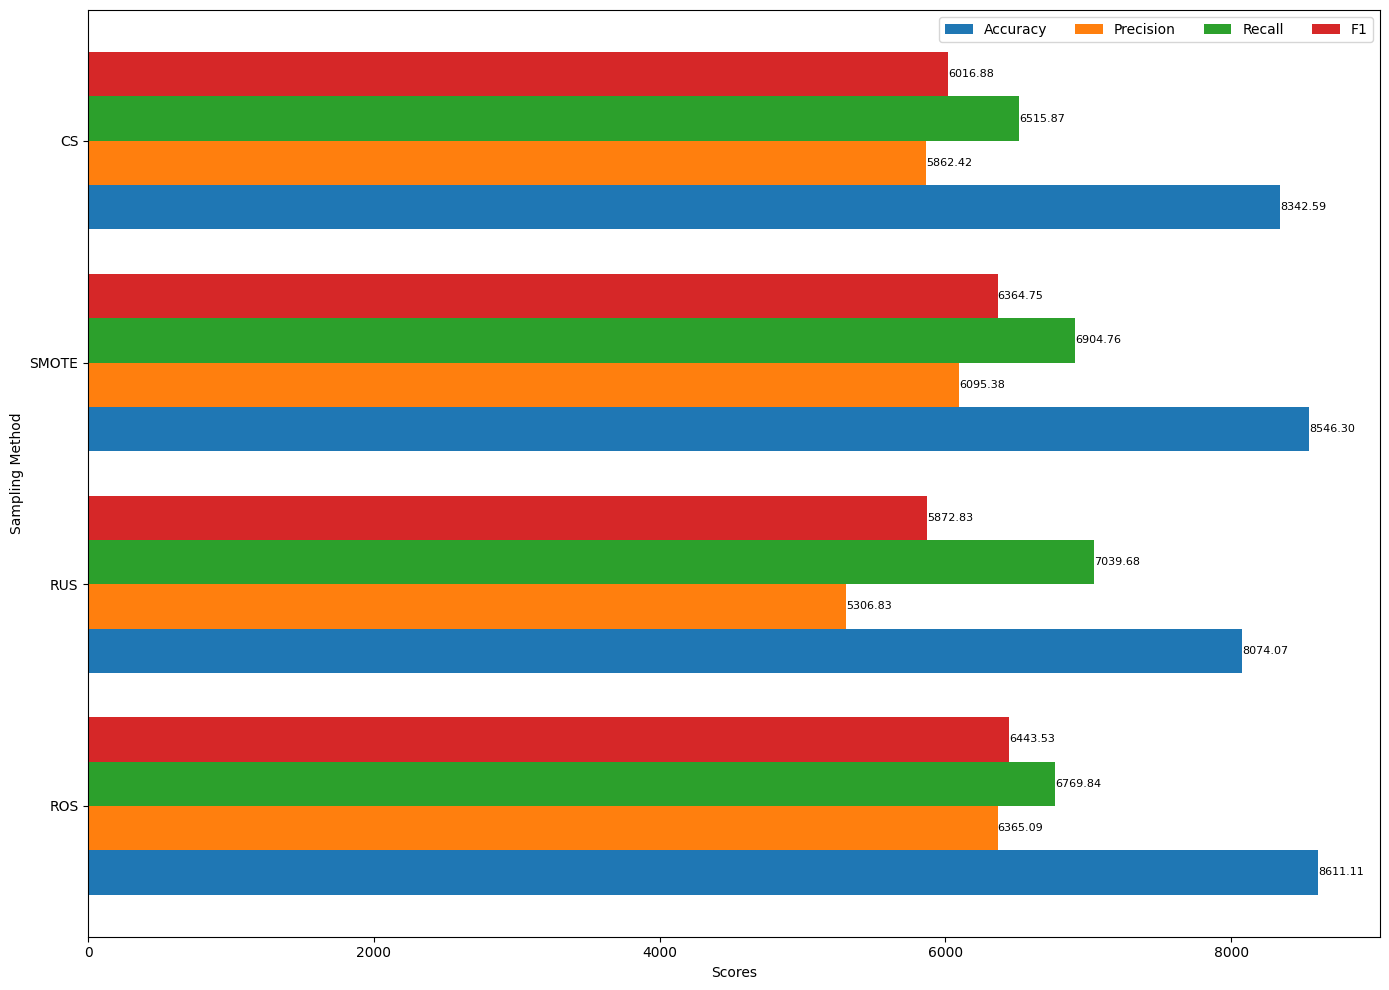

--- Gaussian with 21 features


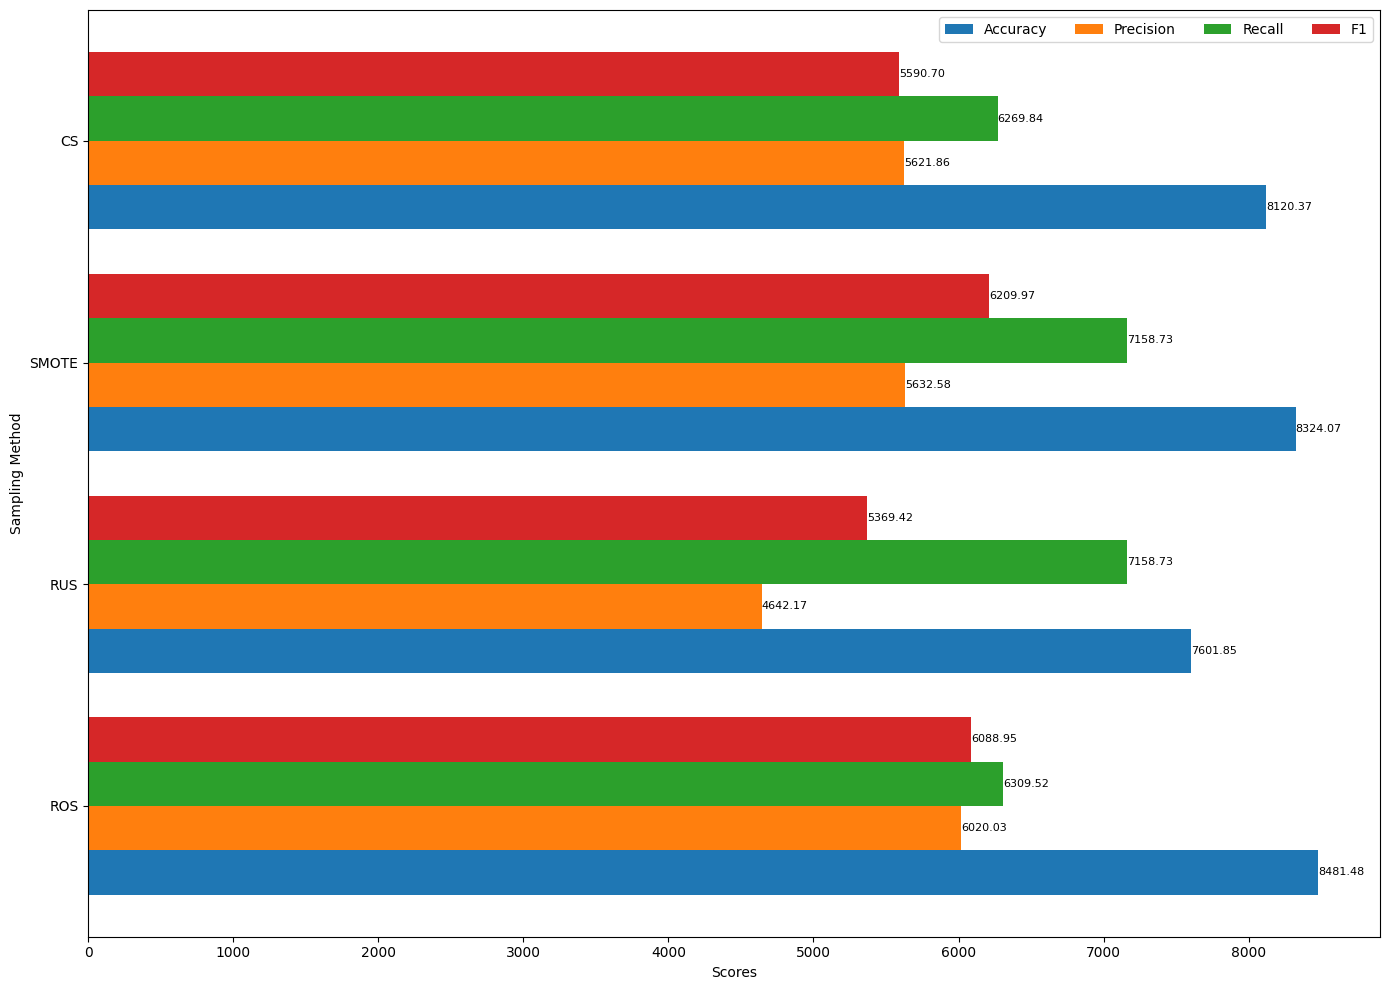

--- Gaussian with 32 features


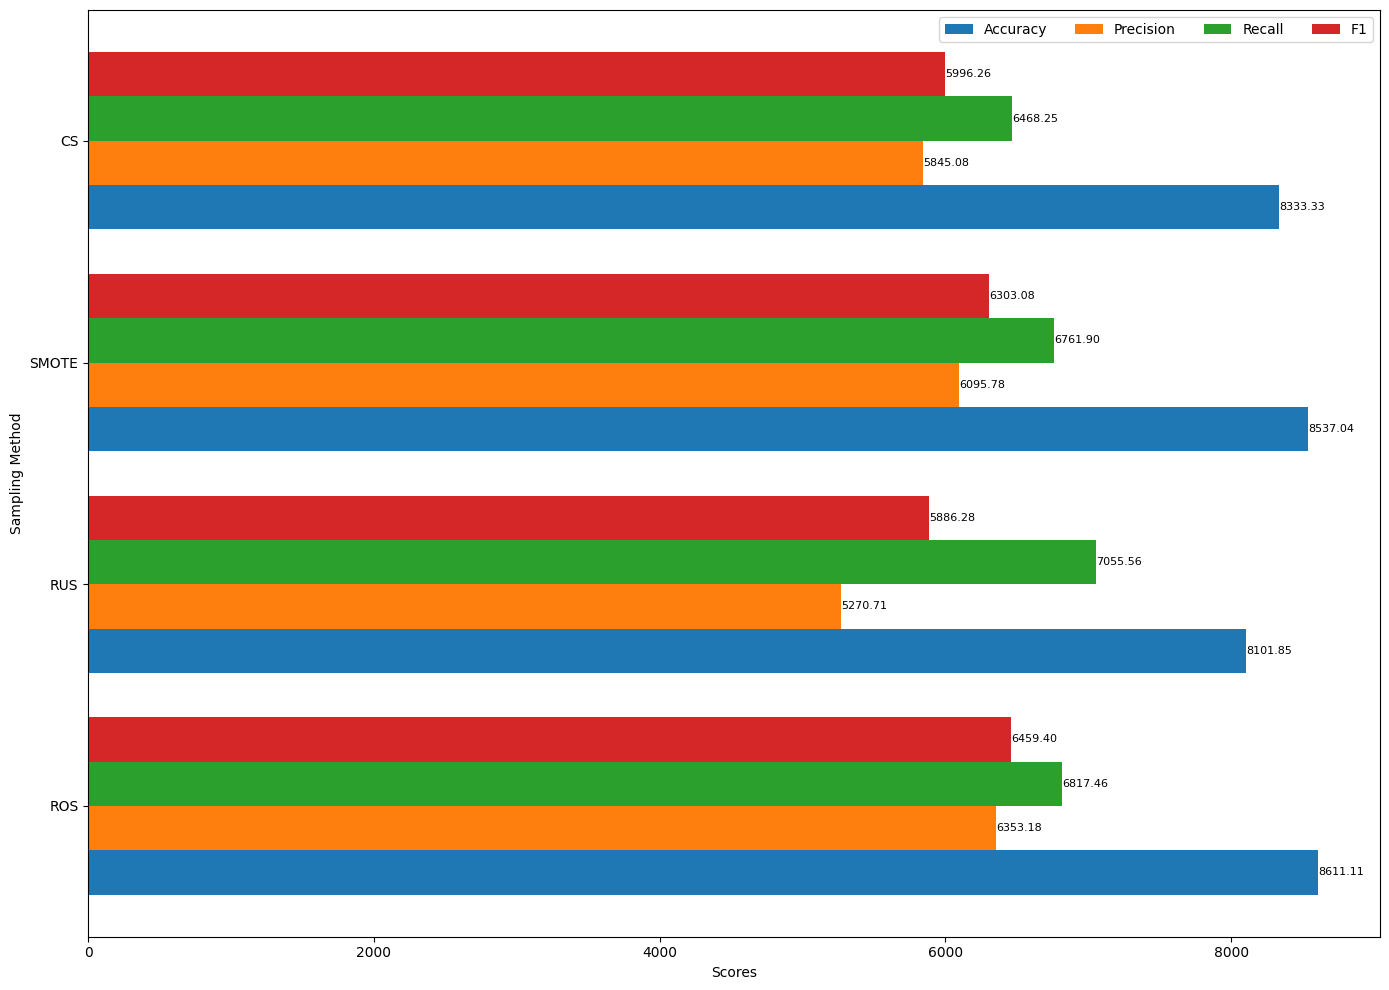

--- Support Vector Machine with 33 features


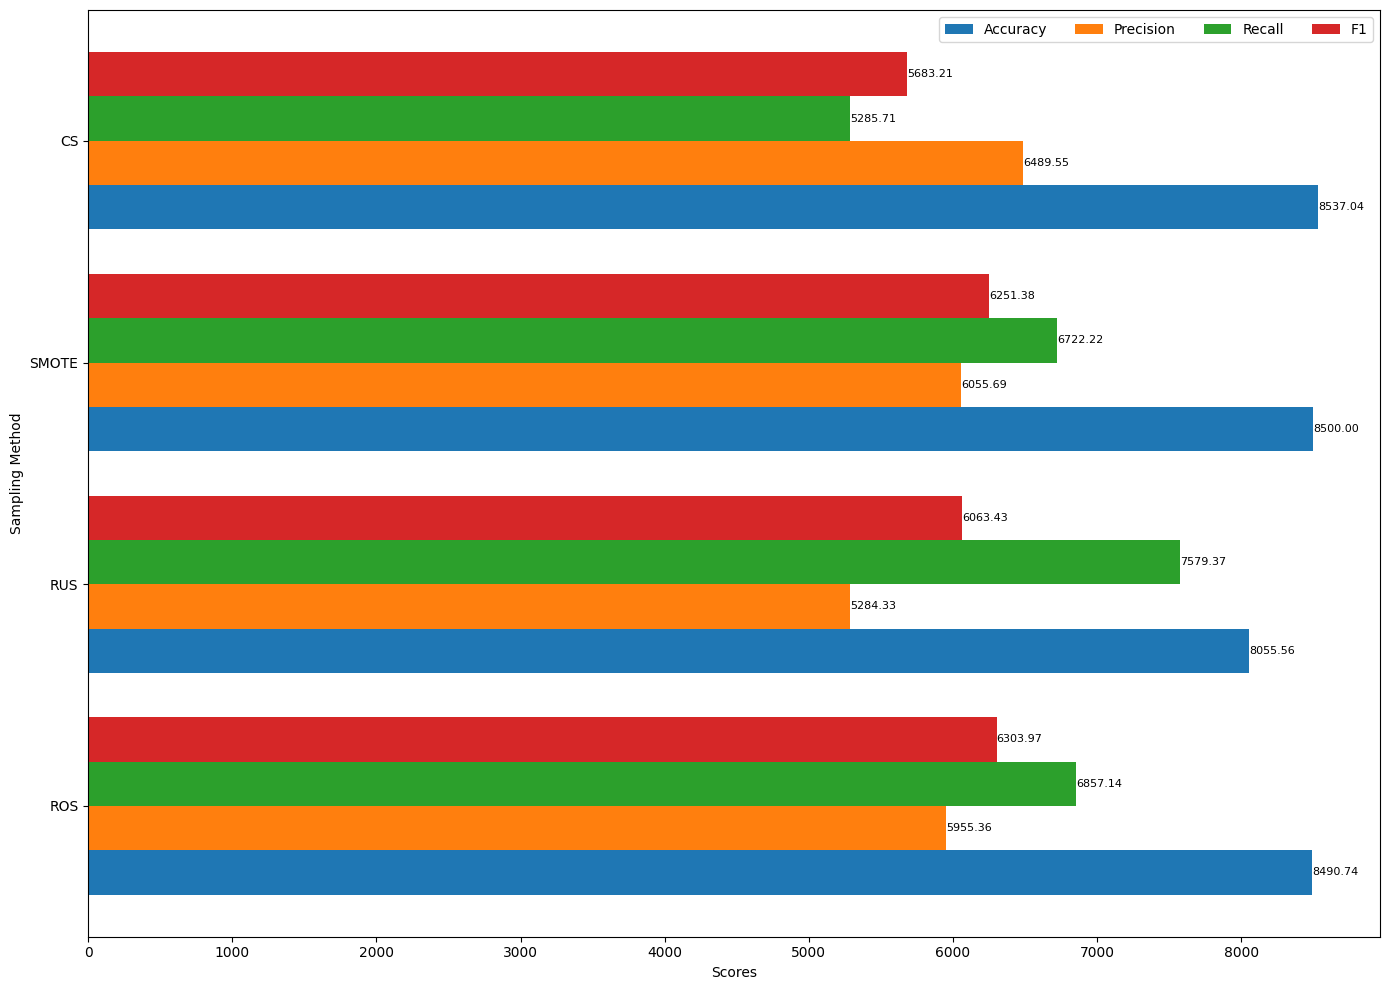

--- Support Vector Machine with 21 features


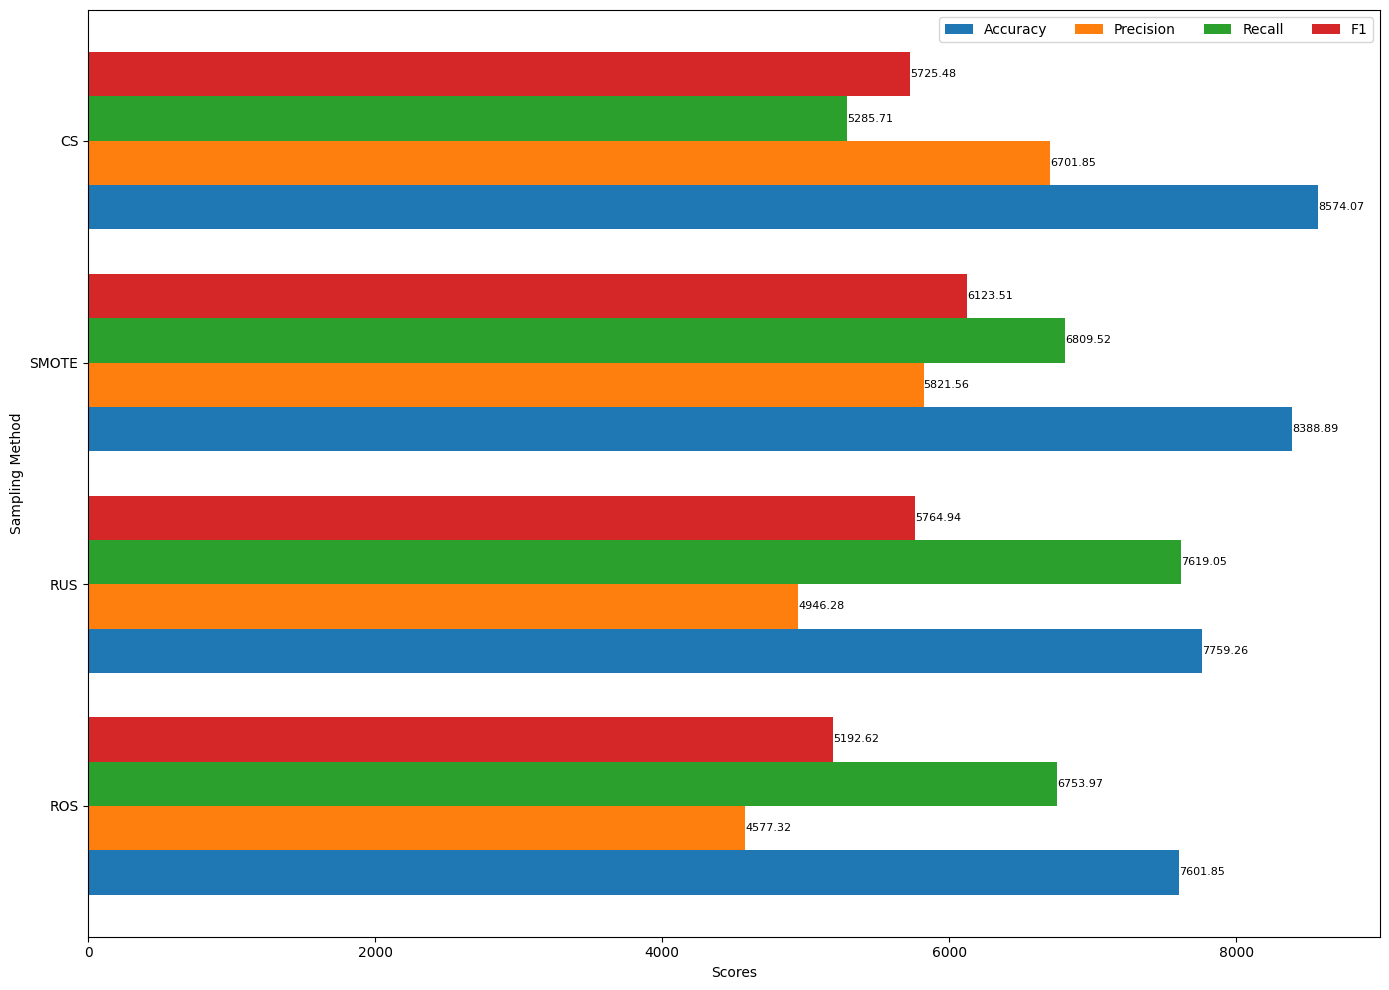

--- Support Vector Machine with 32 features


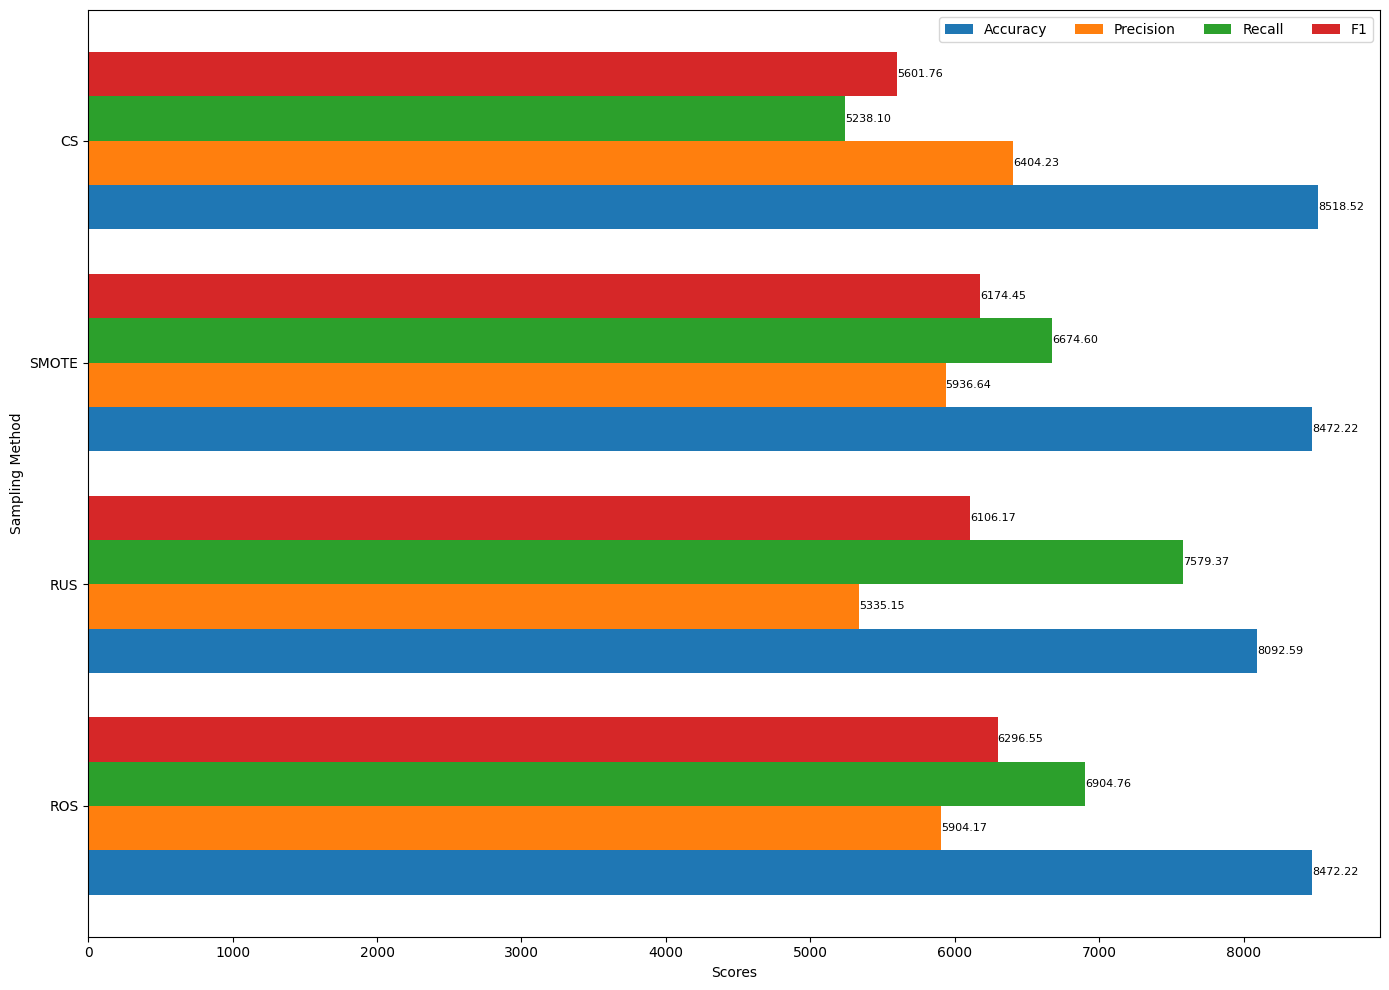

In [84]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

experiment_results = []

for clf_name in ['Gaussian', 'Support Vector Machine']:
    results = []
    clf = models[clf_name]

    sFlag = 0
    eFlag = 4

    for num_feature in num_features:

        samplers = {
            f'ROS': RandomOverSampler(random_state=RANDOM_STATE),
            f'RUS': RandomUnderSampler(random_state=RANDOM_STATE),
            f'SMOTE': SMOTE(random_state=RANDOM_STATE)
            }

        for name, sampler in samplers.items():
            result = {
                'model': clf_name,
                'resampling': name,
                'n_features': num_feature
            }

            steps = [
                ('sampler', sampler),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(score_func=f_classif, k=num_feature)),
                ('model', clf)
            ]

            pipeline = Pipeline(steps=steps)


            for scoring in ['accuracy', 'precision', 'recall', 'f1']:
                scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
                result[scoring] = np.mean(scores) * 100

            results.append(result)
            

        N_RESAMPLE = 30

        scores = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        result = {
            'model': f'{clf_name}',
            'resampling': 'CS',
            'n_features': num_feature
        }

        for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            df_res = df_fe.iloc[train_idx, :].groupby('ABN').apply(
                lambda x: x.sample(N_RESAMPLE, replace=True, random_state=RANDOM_STATE)
            ).reset_index(drop=True)

            # Split to feature and label
            X_res = df_res.drop(columns=columns)
            y_res = df_res['ABN_bin']

            # Create the pipeline
            pipeline_cs = Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(score_func=f_classif, k=num_feature)),
                ('classifier', clf)
            ])

            pipeline_cs.fit(X_res, y_res)

            Xr_test = df_fe.iloc[test_idx, :].drop(columns=columns)
            yr_test = df_fe.iloc[test_idx, :]['ABN_bin']

            y_pred = pipeline_cs.predict(Xr_test)
            
            scores['accuracy'].append(accuracy_score(yr_test, y_pred))
            scores['precision'].append(precision_score(yr_test, y_pred))
            scores['recall'].append(recall_score(yr_test, y_pred))
            scores['f1'].append(f1_score(yr_test, y_pred))

        for scoring in ['accuracy', 'precision', 'recall', 'f1']:
            result[scoring] = np.mean(scores[scoring]) * 100

        results.append(result)
    
        print(f'--- {clf_name} with {num_feature} features')
        graph_ymodel_performance(pd.DataFrame(results[sFlag:eFlag]), y_axis='resampling', y_labels='Sampling Method')

        sFlag = eFlag
        eFlag += 4

    [experiment_results.append(result) for result in results]
    
experiment_results = pd.DataFrame(experiment_results)

In [85]:
np.round(experiment_results, decimals=2)

,model,resampling,n_features,accuracy,precision,recall,f1
0,Gaussian,ROS,33,86.11,63.65,67.70,64.44
1,Gaussian,RUS,33,80.74,53.07,70.40,58.73
2,Gaussian,SMOTE,33,85.46,60.95,69.05,63.65
3,Gaussian,CS,33,83.43,58.62,65.16,60.17
4,Gaussian,ROS,21,84.81,60.20,63.10,60.89
5,Gaussian,RUS,21,76.02,46.42,71.59,53.69
6,Gaussian,SMOTE,21,83.24,56.33,71.59,62.10
7,Gaussian,CS,21,81.20,56.22,62.70,55.91
8,Gaussian,ROS,32,86.11,63.53,68.17,64.59
9,Gaussian,RUS,32,81.02,52.71,70.56,58.86


In [86]:
experiment_results.sort_values('accuracy', ascending=False)[:5]

,model,resampling,n_features,accuracy,precision,recall,f1
0,Gaussian,ROS,33,86.111111,63.650895,67.698413,64.435285
8,Gaussian,ROS,32,86.111111,63.531848,68.174603,64.594015
19,Support Vector Machine,CS,21,85.740741,67.018519,52.857143,57.254752
2,Gaussian,SMOTE,33,85.462963,60.953805,69.047619,63.647508
15,Support Vector Machine,CS,33,85.370370,64.895503,52.857143,56.832140


In [87]:
experiment_results.sort_values('precision', ascending=False)[:5]

,model,resampling,n_features,accuracy,precision,recall,f1
19,Support Vector Machine,CS,21,85.740741,67.018519,52.857143,57.254752
15,Support Vector Machine,CS,33,85.370370,64.895503,52.857143,56.832140
23,Support Vector Machine,CS,32,85.185185,64.042328,52.380952,56.017621
0,Gaussian,ROS,33,86.111111,63.650895,67.698413,64.435285
8,Gaussian,ROS,32,86.111111,63.531848,68.174603,64.594015


In [88]:
experiment_results.sort_values('recall', ascending=False)[:5]

,model,resampling,n_features,accuracy,precision,recall,f1
17,Support Vector Machine,RUS,21,77.592593,49.462768,76.190476,57.649398
21,Support Vector Machine,RUS,32,80.925926,53.351511,75.793651,61.061744
13,Support Vector Machine,RUS,33,80.555556,52.843308,75.793651,60.634298
5,Gaussian,RUS,21,76.018519,46.421680,71.587302,53.694212
6,Gaussian,SMOTE,21,83.240741,56.325834,71.587302,62.099732


In [89]:
experiment_results.sort_values('f1', ascending=False)[:5]

,model,resampling,n_features,accuracy,precision,recall,f1
8,Gaussian,ROS,32,86.111111,63.531848,68.174603,64.594015
0,Gaussian,ROS,33,86.111111,63.650895,67.698413,64.435285
2,Gaussian,SMOTE,33,85.462963,60.953805,69.047619,63.647508
12,Support Vector Machine,ROS,33,84.907407,59.553632,68.571429,63.039736
10,Gaussian,SMOTE,32,85.370370,60.957774,67.619048,63.030830


In [93]:
def evalute_model(clf, n_feature, sampler, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=n_feature)),
        ('classifier', clf)
    ])    
    
    X_res, y_res = sampler.fit_resample(X_train, y_train)

    pipeline.fit(X_res, y_res)

    y_pred = pipeline.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', display_labels=['Normal', 'Abnormal'])
    plt.show()

def evalute_model_cs(clf, n_feature, df, X_train, X_test, y_test):
    df_res = df.iloc[X_train.index, :].groupby('ABN').apply(
        lambda x: x.sample(N_RESAMPLE, replace=True, random_state=RANDOM_STATE)
    ).reset_index(drop=True)

    # Split to feature and label
    X_res = df_res.drop(columns=columns)
    y_res = df_res['ABN_bin']

    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=n_feature)),
        ('classifier', clf)
    ])

    pipeline.fit(X_res, y_res)

    y_pred = pipeline.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', display_labels=['Normal', 'Abnormal'])
    plt.show()

### Accuracy: GNB, ROS, 33

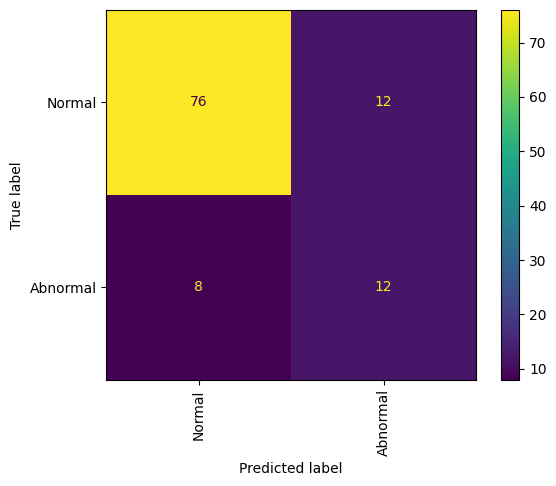

In [97]:
evalute_model(
    clf=SVC(random_state=RANDOM_STATE),
    n_feature=33,
    sampler=RandomOverSampler(random_state=RANDOM_STATE),
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

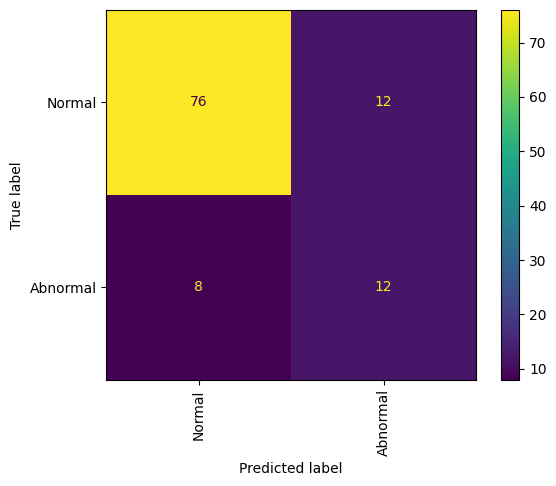

In [98]:
evalute_model(
    clf=SVC(random_state=RANDOM_STATE),
    n_feature=32,
    sampler=RandomOverSampler(random_state=RANDOM_STATE),
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

### Precision: SVM, CS, 21

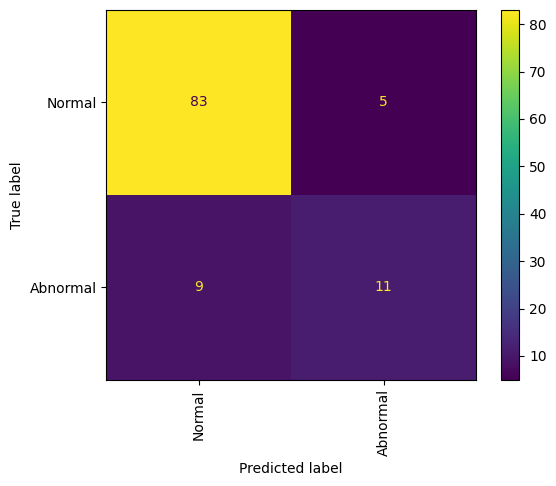

In [99]:
evalute_model_cs(
    clf=SVC(random_state=RANDOM_STATE),
    n_feature=21,
    df=df_fe,
    X_train=X_train,
    X_test=X_test,
    y_test=y_test
)

### Recall: SVM, RUS, 21

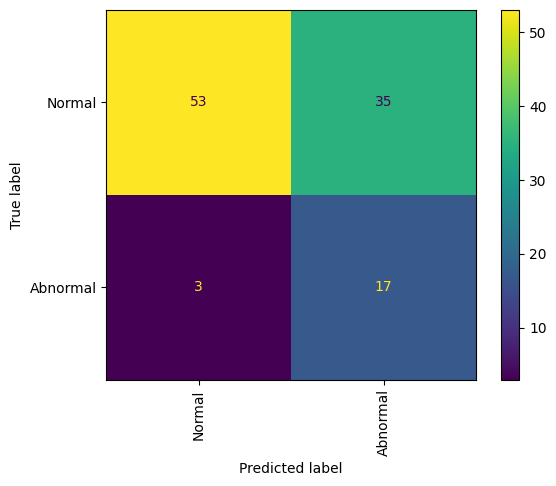

In [100]:
evalute_model(
    clf=SVC(random_state=RANDOM_STATE),
    n_feature=21,
    sampler=RandomUnderSampler(random_state=RANDOM_STATE),
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

### F1-Score: GNB, ROS, 32

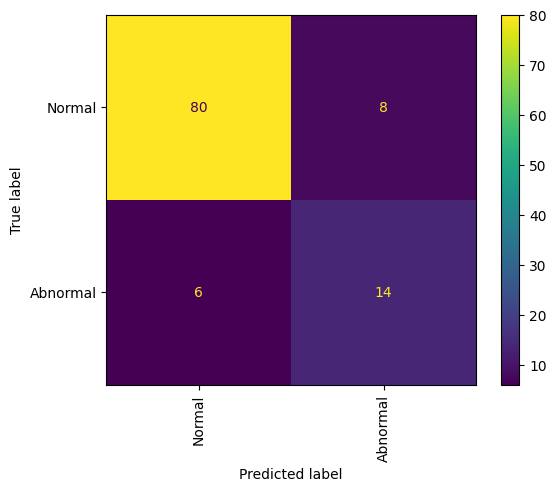

In [101]:
evalute_model(
    clf=GaussianNB(),
    n_feature=32,
    sampler=RandomOverSampler(random_state=RANDOM_STATE),
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

### Feature Engineering with Custom Oversampling

In [ ]:
N_RESAMPLE = 30

df_res = df_fe.iloc[X_train.index, :].groupby('ABN').apply(
    lambda x: x.sample(N_RESAMPLE, replace=True, random_state=RANDOM_STATE)
).reset_index(drop=True)

# Split to feature and label
X_res = df_res.drop(columns=columns)
y_res = df_res['ABN_bin']

print(f"Original Data Number: {len(X_train)}")
print(f"Resample Data Number: {len(X_res)}")
original_resample(y_train, y_res)

In [ ]:
results = []
for sampling in np.arange(10, 60, 10):
    df_res = df_fe.iloc[X_train.index, :].groupby('ABN').apply(
        lambda x: x.sample(sampling, replace=True, random_state=RANDOM_STATE)
    ).reset_index(drop=True)

    # Split to feature and label
    X_res = df_res.drop(columns=columns)
    y_res = df_res['ABN_bin']

    # Fit the pipeline
    pipeline.fit(X_res, y_res)

    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

    result = {
        'number_sampling': sampling
    }

    for scoring in ['accuracy', 'precision', 'recall', 'f1']:
        scores = cross_val_score(pipeline, X_res, y_res, scoring=scoring, cv=cv, n_jobs=-1)
        result[scoring] = np.mean(scores)

    results.append(result)

results = pd.DataFrame(results)

In [ ]:
results.sort_values('f1', ascending=False)

In [ ]:
graph_ymodel_performance(results, y_axis='number_sampling', y_labels='Number of Sampling')

In [ ]:
clf = models['Gausian']

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=30)),
    ('classifier', clf)
])

# Fit the pipeline
pipeline.fit(X_res, y_res)

# Make predictions
y_pred = pipeline.predict(X_test)

# Message
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')
plt.show()

In [ ]:
pipeline.named_steps['feature_selection'].get_feature_names_out(
        input_features=X_train.columns
)

In [ ]:
results = []
result = {}

# evaluate pipeline
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    result[scoring] = np.mean(scores)
    print(f"The average scoring of {scoring}: {np.mean(scores)}")

results = pd.DataFrame(result, index=[0])

In [ ]:
results

### Gausian Hyperparameter Tuning

In [ ]:
TUNING_SCORING = 'accuracy'

In [ ]:
# Resampling data
X_res, y_res = ros.fit_resample(X_train, y_train)

# Define pipeline steps
steps = [
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=30)),
    ('model', models['Gausian'])
]

clf = Pipeline(steps=steps)

# Set up the parameter grid
param_grid = {
    'model__var_smoothing': np.logspace(0, -9, num=1000)  # A range of values for var_smoothing
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring=TUNING_SCORING, 
                           cv=5,  # Number of cross-validation folds
                           verbose=1)

# Fit the model
grid_search.fit(X_res, y_res)

# Retrieve the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Hyperparameter
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

print('\n--- Results Hyperparameter Tuning Gaussian Naive Bayes (GaussianNB) ---')
for scoring in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cross_val_score(grid_search.best_estimator_, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    print(f"The average scoring of {scoring}: {np.mean(scores)}")

# Make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Message
print('\n--- Classification Report ---')
print(classification_report(y_test, y_pred, target_names=np.unique(y_train.astype(str)), zero_division=True))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')
plt.show()